<h1><center>MODELO DE MOROSIDAD - FACTUREDO</center></h1>

**Índice**   
1. [Cargar módulos y funciones](#id1)
2. [Comprensión del Negocio](#id2)
3. [Comprensión de los datos](#id3)<br>
    3.1 [Cargar datos](#id3.1)<br>
    3.2 [Exploración de variables discretas](#id3.2)<br>
    3.3 [Exploración de variables continuas](#id3.3)<br>
4. [Preparación de los datos](#id4)<br>
    4.1 [Tratamiento de variables discretas](#id4.1)<br>
    4.2 [Tratamiento de variables continuas](#id4.2)<br>
    4.3 [Transaformación WOE](#id4.3)<br>
    4.4 [Tratamiento de Outliers](#id4.4)   
    4.5 [Escalamiento](#id4.5)<br> 
    4.6 [Balanceo del target](#id4.6)<br>
    4.7 [Selección de variables](#id4.7)<br>
    4.8 [Partición Train y Test](#id4.8)<br>
5. [Modelación](#id5) <br>
    5.1 [Optimización de hiperparámetros](#id5.1)<br>
    5.2 [Modelos bases optimizados](#id5.2)<br>
    5.2 [Variables más relevandes de los modelos](#id5.3)<br>
6. [Evaluación del modelo](#id6)

<a name="id1"></a> <h3>CARGAR MÓDULOS Y FUNCIONES</h3> 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')
os.chdir('E:\\OMAR\\KAGGLE\\FACTUREO\\Datos')
# os.listdir()

In [2]:
def encontrar_outliers(data,col):
    outliers=[]
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limit=Q3+(1.5*IQR)
    for out1 in db[col]:
        if out1>upper_limit or out1<lower_limit:
            outliers.append(out1)
    return np.array(outliers)

def graficos(data,col,hue):
    fix,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.boxplot(y=data[col],ax=ax1)
    ax1.set_ylabel=col
    ax1.set_title('Gráfico de cajas de {}'.format(col))
    sns.histplot(data,x=col,hue=hue,kde=True,ax=ax2)
    ax2.set_title('Distribution plot of {}'.format(col))
    
def analisis_numerico(data,col,hue):
    print('Cantidad de outlier:',len(encontrar_outliers(data,col)))
    print('Media:',format(data[col].mean()))
    print('Mediana:',format(data[col].median()))
    print('Q1:',format(data[col].quantile(0.25)))
    print('Q3:',format(data[col].quantile(0.75)))
    print('max:',format(data[col].max()))
    graficos(data,col,hue)

In [3]:
def trat_outliers(data,x):
    p1 = data[x].quantile(0.1)
    p90 = data[x].quantile(0.90)    
    data[x] = np.where(data[x] < p1, p1, data[x])
    data[x] = np.where(data[x] > p90, p90, data[x])
    
from Features import *
from AttributeRelevance import *
iv = IV()

def mapwoe_num(data,feature,data_test):
    t1=ContinuousFeature(data,feature)
    iv_df, iv_value = iv.calculate_iv(t1)
    bins=list(iv_df[feature])
    bins.append(1000000000000000)
    grupo=list(iv_df['woe'])
    data[feature+'_woe']=pd.cut(data[feature],bins,labels=grupo)
    data_test[feature+'_woe']=pd.cut(data_test[feature],bins,labels=grupo)
#     return bins,grupo
    
def mapwoe_cat(data,feature,data_test):
    t1=CategoricalFeature(data,feature)
    iv_df, iv_value = iv.calculate_iv(t1)
    t1_cat={}
    n=len(list(iv_df[feature]))
    for i in range(0,n):
        k=list(iv_df[feature])[i]
        v=list(iv_df['woe'])[i]
        t1_cat[k]=v
    data[feature+'_woe']=data[feature].map(t1_cat)
    data_test[feature+'_woe']=data_test[feature].map(t1_cat)
#     return t1_cat

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

def undersampling(x,y,ratio,semilla=1812):
    us=RandomUnderSampler(sampling_strategy=ratio,random_state=semilla)
    X_bal,y_bal=us.fit_resample(x,y)
    print ("Dimensión antes del remuestreo {}".format(Counter(y.squeeze())))
    print ("Dimensión después del remuestreo {}".format(Counter(y_bal.squeeze())))
    return X_bal,y_bal

def oversampling(x,y,ratio,semilla=1812):
    os=RandomOverSampler(sampling_strategy=ratio,random_state=semilla)
    X_bal,y_bal=os.fit_resample(x,y)
    print ("Dimensión antes del remuestreo {}".format(Counter(y.squeeze())))
    print ("Dimensión después del remuestreo {}".format(Counter(y_bal.squeeze())))
    return X_bal,y_bal

def smote(x,y,ratio,semilla=1812):
    sm=SMOTE(sampling_strategy=ratio,random_state=semilla)
    X_bal,y_bal=sm.fit_resample(x,y)
    print ("Dimensión antes del remuestreo {}".format(Counter(y.squeeze())))
    print ("Dimensión después del remuestreo {}".format(Counter(y_bal.squeeze())))
    return X_bal,y_bal

In [5]:
# agrupemos los comandos anteriores en dos funciones

def target_encoder(data, variable, target,data_test):
    tmp = pd.DataFrame(data.groupby([variable])[target].mean())    
    tmp['non-target'] = 1 - tmp[target]    
    tmp['ratio'] = tmp[target] / tmp['non-target']
    t1_dict=tmp['ratio'].to_dict()
    data[variable+'_tg'] = data[variable].map(t1_dict)
    data_test[variable+'_tg'] = data_test[variable].map(t1_dict)


In [6]:
def m_logistico(X_train,y_train):
    from sklearn import linear_model
    logreg = linear_model.LogisticRegression(class_weight="balanced",
                                             tol=0.001,
                                             max_iter=500,
                                             random_state = 11)
    return logreg.fit(X_train,y_train)
    
def m_elastic(X_train,y_train):
    from sklearn.linear_model import LogisticRegression
    elastic = LogisticRegression(penalty = 'elasticnet',
                                class_weight="balanced",
                                solver = 'saga',
                                C = 0.4,
                                l1_ratio = 0.9,
                                max_iter=1000,
                                random_state = 11)
    return elastic.fit(X_train,y_train)

def m_arbol(X_train,y_train):
    from sklearn.tree import DecisionTreeClassifier
    dtree = DecisionTreeClassifier(max_depth = 50,
                                   min_samples_leaf = 1e-05,
                                   class_weight = {0:y_train.mean(),1:1},
                                   random_state = 11)
    return dtree.fit(X_train,y_train)

def m_random(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators = 200,
                                 max_depth = 45, 
                                 min_samples_leaf = 1e-06,
                                 class_weight = {0:y_train.mean(),1:1},
                                 oob_score = True,
                                 verbose = 1, 
                                 n_jobs = -1,
                                 random_state = 11)
    return rfc.fit(X_train,y_train)

def m_adaboost(X_train,y_train):
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    ada_clf = AdaBoostClassifier(
              DecisionTreeClassifier(max_depth = 6),
              n_estimators = 50,
              algorithm = 'SAMME.R',
              learning_rate = 0.1,
              random_state = 123)
    return ada_clf.fit(X_train,y_train)

def m_logistico_woe(X_train,y_train):
    from sklearn import linear_model
    logreg = linear_model.LogisticRegression(class_weight="balanced",
                                             tol=0.001,
                                             max_iter=50,
                                             random_state = 11)
    return logreg.fit(X_train,y_train)
    
def m_elastic_woe(X_train,y_train):
    from sklearn.linear_model import LogisticRegression
    elastic = LogisticRegression(penalty = 'elasticnet',
                                class_weight="balanced",
                                solver = 'saga',
                                C = 0.35,
                                l1_ratio = 0.99,
                                max_iter=10,
                                random_state = 11)
    return elastic.fit(X_train,y_train)

def m_arbol_woe(X_train,y_train):
    from sklearn.tree import DecisionTreeClassifier
    dtree = DecisionTreeClassifier(max_depth = 50,
                                   min_samples_leaf = 1e-05,
                                   class_weight = {0:y_train.mean(),1:1},
                                   random_state = 11)
    return dtree.fit(X_train,y_train)

def m_random_woe(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators = 10,
                                 max_depth = 45,
                                 min_samples_leaf = 1e-06,
                                 class_weight = {0:y_train.mean(),1:1},
                                 oob_score = True,
                                 verbose = 1, 
                                 n_jobs = -1,
                                 random_state = 123)
    return rfc.fit(X_train,y_train)

def m_adaboost_woe(X_train,y_train):
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    ada_clf = AdaBoostClassifier(
              DecisionTreeClassifier(max_depth = 6),
              n_estimators = 50,
              algorithm = 'SAMME.R',
              learning_rate = 0.1,
              random_state = 11)
    return ada_clf.fit(X_train,y_train)

In [7]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn import metrics

def report_param(y_t,y_p):
    print('Classification report:\n\n{}'.format(
      metrics.classification_report(y_t,y_p, digits = 6)
    ))

def conf_m(model,X_t,y_t):
    print("\nMatriz de Confusión")
    disp = metrics.plot_confusion_matrix(model, X_t, y_t,
                                cmap=plt.cm.Blues,
                                values_format="")
    disp.ax_.set_title("Confusion Matrix")
    plt.show()

def fig_ROC(y_t,y_s):
  # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in [0,1]:
        fpr[i], tpr[i], _ = roc_curve(y_t, y_s)
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_t.ravel(), y_s.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print("\nGráfico ROC")
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.0001, 1.0])
    plt.ylim([0.0, 1.0001])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def total_param(model, X_t, y_t):
    # Model: Modelo a evaluar
    # X_t: Datos de X_test
    # y_t: Datos de y_test
    y_p = model.predict(X_t) #Valores predichos
    y_s = model.predict_proba(X_t)[:, 1] #Probabilidad para cada valor de clase 1
    conf_m(model,X_t,y_t) #Gráfico de Matriz de Confusión
    report_param(y_t,y_p) #Reporte de parametros
    fig_ROC(y_t,y_s)  #Gráfico ROC

 <a name="id2"></a><h1><center>COMPRENSIÓN DEL NEGOCIO</center></h1>

**Objetivo de Negocio:** 
"*Reducir la morosidad de pagos*"

**Problema de Machine Learning:** Clasificación

**Objetivo Machine Learning:**
"*Construir un modelo que identifique a los cliente más propensos a ser morosos*"

<a name="id3"></a><h1><center>COMPRENSIÓN DE LOS DATOS</center></h1> 

<a name="id3.1"></a> <h3>CARGAR DATOS</h3> 

In [8]:
X_train=pd.read_csv('train.csv',header=0,index_col=0)
X_test=pd.read_csv('test.csv',header=0,index_col=0)
y_train=pd.read_csv('train_label.csv',names=['label'],header=None)
y_test=pd.read_csv('test_label.csv',names=['label'],header=None)

In [9]:
X_train.index.names = ['id']
X_train.reset_index(inplace=True)

X_test.index.names = ['id']
X_test.reset_index(inplace=True)

In [10]:
db=pd.concat([X_train,y_train],axis=1)

In [11]:
db.shape

(2189, 73)

In [12]:
db.columns

Index(['id', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'tcs37', 'tcs38', 'tcs39',
       'tcs40', 'tcs41', 'tcs42', 'tc43', 'tc44', 'tc45', 'tc46', 'tc47',
       'tc48', 'tc49', 'tc50', 'tc51', 'tc52', 'tc53', 'dv54', 'ae55', 'ae56',
       'ae57', 'ae58', 'ae59', 'ae60', 'ae61', 'ae62', 'ae63', 'ae64', 'ae65',
       'ae66', 'ae67', 'ae68', 'd69', 'd70', 'label'],
      dtype='object')

In [13]:
db.iloc[:,0:15].head()

,id,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13
0,1651,0.00,143270.10,100.0,0.0,0.0,63090564.44,4199850.00,0.0,6240000.0,17.0,643.0,6.0,0.00,0.0
1,1370,0.00,1403461.97,90.0,10.0,29.0,8013913.78,8177030.69,44951.9,0.0,12.0,475.0,6.0,5700426.25,0.0
2,2649,19800.24,63401.41,100.0,0.0,0.0,323384.60,67610.22,0.0,0.0,4.0,634.0,5.0,0.00,0.0
3,564,0.00,10585032.22,100.0,0.0,5.0,29596681.95,186964.54,0.0,4500000.0,11.0,649.0,6.0,3219970.31,0.0
4,2728,0.00,11259663.09,78.0,22.0,0.0,33626595.71,0.00,0.0,3972827.7,24.0,795.0,6.0,247181.79,0.0


In [14]:
db.iloc[:,15:35].head()

,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33
0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,3.259077e+05,15266089.96,8.0,1020.0,-0.633744,0.0,0.0,0.0,0.0,0.0,132
1,0.0,20223.0,0.0,2.0,62781.08,0.00,62781.08,2.0,0.0,0.000000e+00,0.00,4.0,1290.0,6.699532,100.0,0.0,2.0,100.0,0.0,228
2,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.000000e+00,0.00,0.0,8.0,-0.503667,0.0,0.0,0.0,0.0,0.0,64
3,0.0,0.0,0.0,0.0,0.00,604199.98,0.00,0.0,0.0,2.519000e+07,2559635.98,8.0,18.0,-1.970372,0.0,0.0,0.0,0.0,0.0,720
4,0.0,848.0,848.0,0.0,0.00,0.00,0.00,0.0,0.0,3.084651e+04,16134256.08,0.0,487.0,-1.288042,0.0,100.0,0.0,0.0,0.0,968


In [15]:
db.iloc[:,35:55].head()

,v34,v35,v36,tcs37,tcs38,tcs39,tcs40,tcs41,tcs42,tc43,tc44,tc45,tc46,tc47,tc48,tc49,tc50,tc51,tc52,tc53
0,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,31.0,1.0,31.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,31.0,1.0,31.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
db.iloc[:,55:73].head()

,dv54,ae55,ae56,ae57,ae58,ae59,ae60,ae61,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70,label
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0


In [17]:
db.shape

(2189, 73)

<AxesSubplot:>

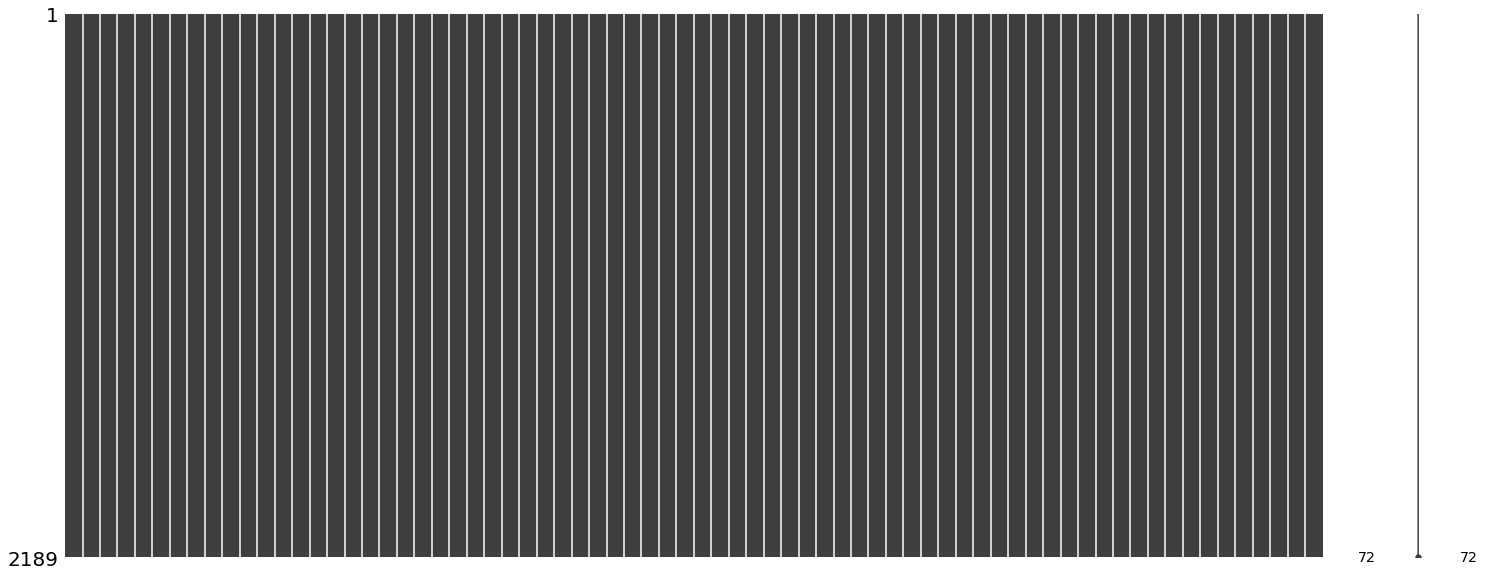

In [18]:
# valores nulos
import missingno as msno
%matplotlib inline
msno.matrix(db.iloc[:,1:74])

<a name="id3.2"></a> <h3>EXPLORACIÓN DE VARIABLES DISCRETAS</h3> 

In [19]:
lista_discretas=[]
for i in db.columns:
    a=len(db[i].unique())
    if a<10:
        lista_discretas.append(i)
        
lista_discretas

['v11',
 'v28',
 'v29',
 'v31',
 'v32',
 'tcs37',
 'tcs38',
 'tcs39',
 'tcs40',
 'tcs41',
 'tcs42',
 'tc43',
 'tc44',
 'tc45',
 'tc46',
 'tc47',
 'tc48',
 'tc49',
 'tc50',
 'tc51',
 'tc52',
 'tc53',
 'dv54',
 'ae55',
 'ae56',
 'ae57',
 'ae58',
 'ae59',
 'ae60',
 'ae61',
 'ae62',
 'ae63',
 'ae64',
 'ae65',
 'ae66',
 'ae67',
 'ae68',
 'd69',
 'd70',
 'label']

0.0    1760
1.0     429
Name: label, dtype: int64
Tasa de éxito: 0.196


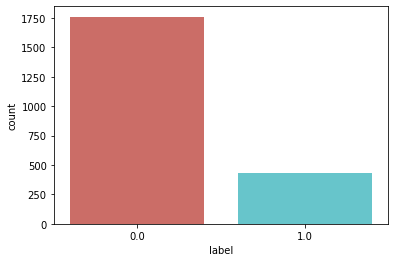

In [20]:
# Analizando el target
print(db.label.value_counts())
sns.countplot(x='label', data = db, palette = 'hls')
print('Tasa de éxito: %.3f'%(db.label.sum()/len(db)))

<font color=red> OJO: El target está desbalanceado, posible tratamiento de smote</font>

In [21]:
# Análisis variable discreta 1
t_discreta1=db[['tcs37', 'tcs38', 'tcs39','tcs40', 'tcs41', 'tcs42']].sum().sort_values(ascending=False).to_frame("cantidad")
t_discreta1.index.name='etiquetas'
t_discreta1=t_discreta1.reset_index()
# t_discreta1['porc']=t_discreta1.cantidad/t_discreta1.cantidad.sum()

<AxesSubplot:xlabel='etiquetas', ylabel='cantidad'>

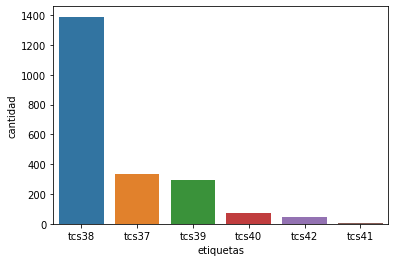

In [22]:
sns.barplot(x='etiquetas',y='cantidad',data=t_discreta1)

In [23]:
db['discreta1']=np.where(db.tcs37==1,'tcs37',
                         np.where(db.tcs38==1,'tcs38',
                                 np.where(db.tcs39==1,'tcs39',
                                         np.where(db.tcs40==1,'tcs40',
                                                 np.where(db.tcs41==1,'tcs41',
                                                          np.where(db.tcs42==1,'tcs42','otro'))))))

X_test['discreta1']=np.where(X_test.tcs37==1,'tcs37',
                         np.where(X_test.tcs38==1,'tcs38',
                                 np.where(X_test.tcs39==1,'tcs39',
                                         np.where(X_test.tcs40==1,'tcs40',
                                                 np.where(X_test.tcs41==1,'tcs41',
                                                          np.where(X_test.tcs42==1,'tcs42','otro'))))))

<AxesSubplot:xlabel='discreta1'>

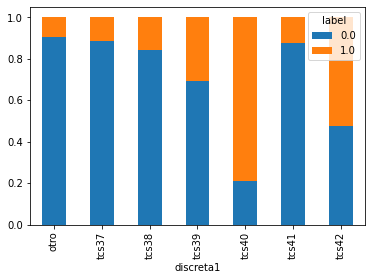

In [24]:
table = pd.crosstab(db.discreta1,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

In [25]:
# Análisis variable discreta 2
t_discreta2=db[['tc43', 'tc44', 'tc45', 'tc46', 'tc47','tc48', 'tc49', 'tc50', 'tc51', 'tc52', 'tc53']].sum().sort_values(ascending=False).to_frame("cantidad")
t_discreta2.index.name='etiquetas'
t_discreta2=t_discreta2.reset_index()

<AxesSubplot:xlabel='etiquetas', ylabel='cantidad'>

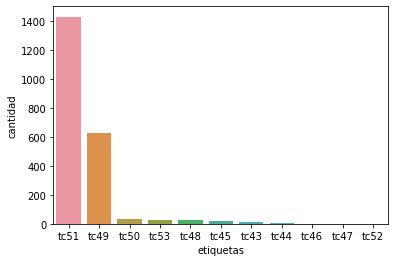

In [26]:
sns.barplot(x='etiquetas',y='cantidad',data=t_discreta2)

In [27]:
db['discreta2']=np.where(db.tc43==1,'tc43',                
                         np.where(db.tc44==1,'tc44',
                                 np.where(db.tc45==1,'tc45',
                                         np.where(db.tc46==1,'tc46',
                                                 np.where(db.tc47==1,'tc47',
                                                          np.where(db.tc48==1,'tc48',
                                                                   np.where(db.tc49==1,'tc49',
                                                                            np.where(db.tc50==1,'tc0',
                                                                                     np.where(db.tc51==1,'tc51',   
                                                                                              np.where(db.tc52==1,'tc52',
                                                                                                       np.where(db.tc53==1,'tc53','otro')))))))))))

X_test['discreta2']=np.where(X_test.tc43==1,'tc43',                
                         np.where(X_test.tc44==1,'tc44',
                                 np.where(X_test.tc45==1,'tc45',
                                         np.where(X_test.tc46==1,'tc46',
                                                 np.where(X_test.tc47==1,'tc47',
                                                          np.where(X_test.tc48==1,'tc48',
                                                                   np.where(X_test.tc49==1,'tc49',
                                                                            np.where(X_test.tc50==1,'tc0',
                                                                                     np.where(X_test.tc51==1,'tc51',   
                                                                                              np.where(X_test.tc52==1,'tc52',
                                                                                                       np.where(X_test.tc53==1,'tc53','otro')))))))))))

<AxesSubplot:xlabel='discreta2'>

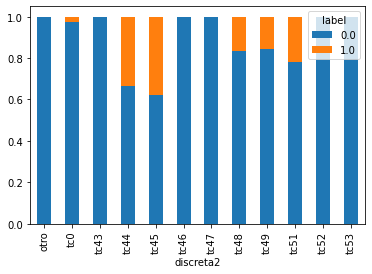

In [28]:
table = pd.crosstab(db.discreta2,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='dv54'>

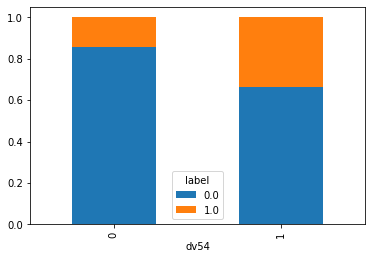

In [29]:
# Análisis de variables discreta dv54
table = pd.crosstab(db.dv54,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

In [30]:
# Análisis variable discreta 3
t_discreta3=db[['ae55', 'ae56','ae57', 'ae58', 'ae59', 'ae60', 'ae61', 'ae62', 'ae63', 'ae64', 'ae65',
'ae66', 'ae67', 'ae68']].sum().sort_values(ascending=False).to_frame("cantidad")
t_discreta3.index.name='etiquetas'
t_discreta3=t_discreta3.reset_index()

<AxesSubplot:xlabel='etiquetas', ylabel='cantidad'>

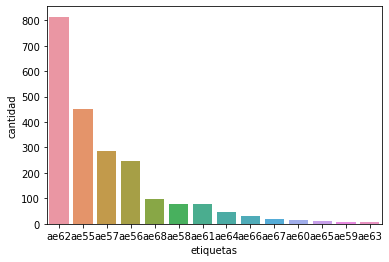

In [31]:
sns.barplot(x='etiquetas',y='cantidad',data=t_discreta3)

In [32]:
db['discreta3']=np.where(db.ae55==1,'ae55',
                         np.where(db.ae56==1,'ae56',
                                 np.where(db.ae57==1,'ae57',
                                         np.where(db.ae58==1,'ae58',
                                                 np.where(db.ae59==1,'ae59',
                                                       np.where(db.ae60==1,'ae60',
                                                                np.where(db.ae61==1,'ae61',
                                                                         np.where(db.ae62==1,'ae62',   
                                                                                  np.where(db.ae63==1,'ae63',
                                                                                           np.where(db.ae64==1,'ae64',
                                                                                                    np.where(db.ae65==1,'ae65',
                                                                                                            np.where(db.ae66==1,'ae66',
                                                                                                                    np.where(db.ae67==1,'ae67',
                                                                                                                             np.where(db.ae68==1,'ae68','otro'))))))))))))))

X_test['discreta3']=np.where(X_test.ae55==1,'ae55',
                         np.where(X_test.ae56==1,'ae56',
                                 np.where(X_test.ae57==1,'ae57',
                                         np.where(X_test.ae58==1,'ae58',
                                                 np.where(X_test.ae59==1,'ae59',
                                                       np.where(X_test.ae60==1,'ae60',
                                                                np.where(X_test.ae61==1,'ae61',
                                                                         np.where(X_test.ae62==1,'ae62',   
                                                                                  np.where(X_test.ae63==1,'ae63',
                                                                                           np.where(X_test.ae64==1,'ae64',
                                                                                                    np.where(X_test.ae65==1,'ae65',
                                                                                                            np.where(X_test.ae66==1,'ae66',
                                                                                                                    np.where(X_test.ae67==1,'ae67',
                                                                                                                             np.where(X_test.ae68==1,'ae68','otro'))))))))))))))

<AxesSubplot:xlabel='discreta3'>

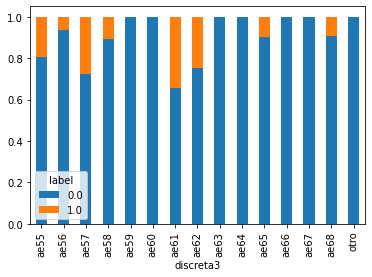

In [33]:
table = pd.crosstab(db.discreta3,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

In [34]:
# Análisis variable discreta 4
db[['d69', 'd70']].sum().sort_values(ascending=False)

d69    268
d70      0
dtype: int64

<AxesSubplot:xlabel='d69'>

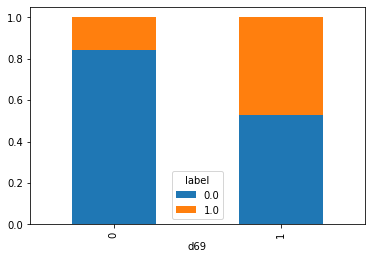

In [35]:
table = pd.crosstab(db.d69,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='v11'>

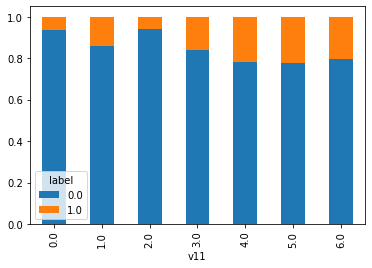

In [36]:
table = pd.crosstab(db.v11,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='v28'>

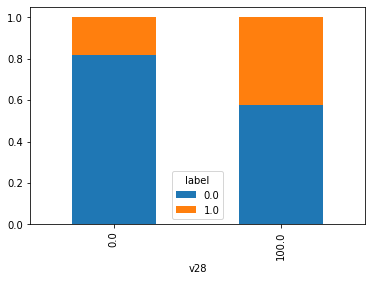

In [37]:
table = pd.crosstab(db.v28,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='v29'>

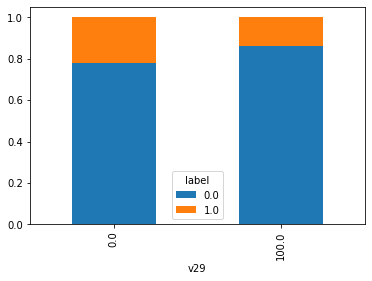

In [38]:
table = pd.crosstab(db.v29,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='v31'>

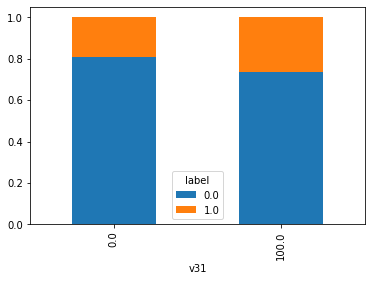

In [39]:
table = pd.crosstab(db.v31,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='v32'>

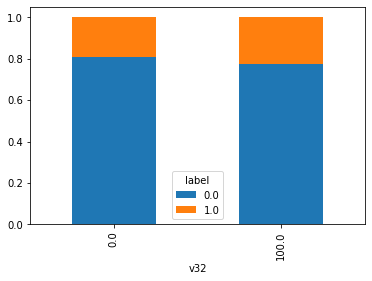

In [40]:
table = pd.crosstab(db.v32,db.label)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

<a name="id3.3"></a> <h3>EXPLORACIÓN DE VARIABLES CONTINUAS</h3> 

In [41]:
lista_continuas=[x for x in X_train.columns if x not in lista_discretas]
lista_continuas.remove('id')

In [42]:
len(lista_continuas)

32

In [43]:
db[lista_continuas[0:16]].describe([0.1,0.25,0.5,0.75,0.85,0.9,0.95,0.98])

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v12,v13,v14,v15,v16
count,2.189000e+03,2.189000e+03,2189.000000,2189.000000,2189.000000,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2189.000000,2189.000000,2.189000e+03,2189.000000,2189.000000,2189.000000,2189.000000
mean,2.789336e+04,2.498074e+06,87.098675,10.317953,3.608040,7.332287e+07,1.011043e+07,1.126268e+04,2.283687e+06,20.920512,672.126999,8.800052e+06,50.050708,82.414801,3090.847419,713.674280
std,2.770920e+05,3.713769e+06,29.548930,25.922405,8.477891,3.009257e+08,4.209394e+07,1.540442e+05,3.283374e+06,13.119688,153.925293,4.259808e+07,388.628760,1058.497846,34525.105979,6590.563127
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
10%,0.000000e+00,0.000000e+00,19.000000,0.000000,0.000000,2.428344e+04,0.000000e+00,0.000000e+00,0.000000e+00,9.000000,484.200000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,1.411988e+04,100.000000,0.000000,0.000000,2.898817e+06,0.000000e+00,0.000000e+00,0.000000e+00,11.000000,610.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,1.781006e+05,100.000000,0.000000,0.000000,1.623024e+07,1.970460e+04,0.000000e+00,0.000000e+00,22.000000,699.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,0.000000e+00,3.958601e+06,100.000000,0.000000,5.000000,3.308427e+07,2.560791e+06,0.000000e+00,4.355600e+06,24.000000,791.000000,5.269417e+05,0.000000,0.000000,0.000000,85.000000
85%,0.000000e+00,6.729709e+06,100.000000,22.000000,7.000000,7.174000e+07,9.312204e+06,0.000000e+00,7.972828e+06,27.000000,803.000000,1.507135e+06,0.000000,0.000000,1188.000000,1188.000000
90%,0.000000e+00,9.694104e+06,100.000000,30.000000,9.000000,1.492350e+08,1.443642e+07,0.000000e+00,8.000000e+06,29.000000,807.000000,3.219970e+06,0.000000,0.000000,1188.000000,1188.000000


Las variables v0,v7,v13,v14,v17,v18,v20,v21 tienen un 85% de valor 0, al tener un gran grupo de registros con un solo valor podría no ayudar a discriminar el target. Una posible solución para no perder dicha variable es agrupando o en todo caso eliminarlo.

La variable v2 tiene más valores 100 que otros valores.Una posible solución para no perder dicha variable es agrupando o en todo caso eliminarlo.

In [44]:
db[lista_continuas[16:33]].describe([0.1,0.25,0.5,0.75,0.85,0.9,0.95,0.98])

,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v30,v33,v34,v35,v36
count,2189.000000,2.189000e+03,2.189000e+03,2.189000e+03,2189.000000,2189.000000,2.189000e+03,2.189000e+03,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000
mean,0.590681,5.224041e+04,1.502924e+05,1.001479e+04,0.460484,1.577889,1.183165e+07,1.344988e+07,4.413888,1003.878483,0.418084,2.038374,421.936501,34.648241,35.711284,34.118776
std,2.589111,4.826651e+05,4.498976e+05,7.167207e+04,2.738098,7.471945,6.341034e+07,4.133237e+07,6.546592,2893.457577,2.443169,8.404936,345.095460,37.067513,59.697032,33.230561
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-3.000000,0.000000,0.000000,-3.000000,-3.000000,-3.000000
10%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,8.000000,-1.541074,0.000000,19.000000,29.000000,1.000000,29.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.629258e+04,0.000000e+00,0.000000,35.000000,-1.288042,0.000000,121.000000,30.000000,1.000000,30.000000
50%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,8.223397e+04,6.466171e+05,0.000000,325.000000,-0.624764,0.000000,323.000000,31.000000,1.000000,31.000000
75%,0.000000,0.000000e+00,1.050000e+05,0.000000e+00,0.000000,0.000000,2.867601e+06,1.321816e+07,7.000000,675.000000,1.389325,0.000000,723.000000,31.000000,62.000000,31.000000
85%,0.000000,0.000000e+00,2.970432e+05,0.000000e+00,0.000000,1.000000,1.785092e+07,1.590375e+07,11.000000,1052.600000,3.099519,1.000000,876.000000,31.000000,121.000000,31.000000
90%,1.000000,2.166900e+04,6.042000e+05,2.073990e+03,0.000000,1.000000,2.622370e+07,1.772860e+07,14.000000,1388.000000,4.581630,2.000000,937.000000,31.000000,123.200000,31.000000


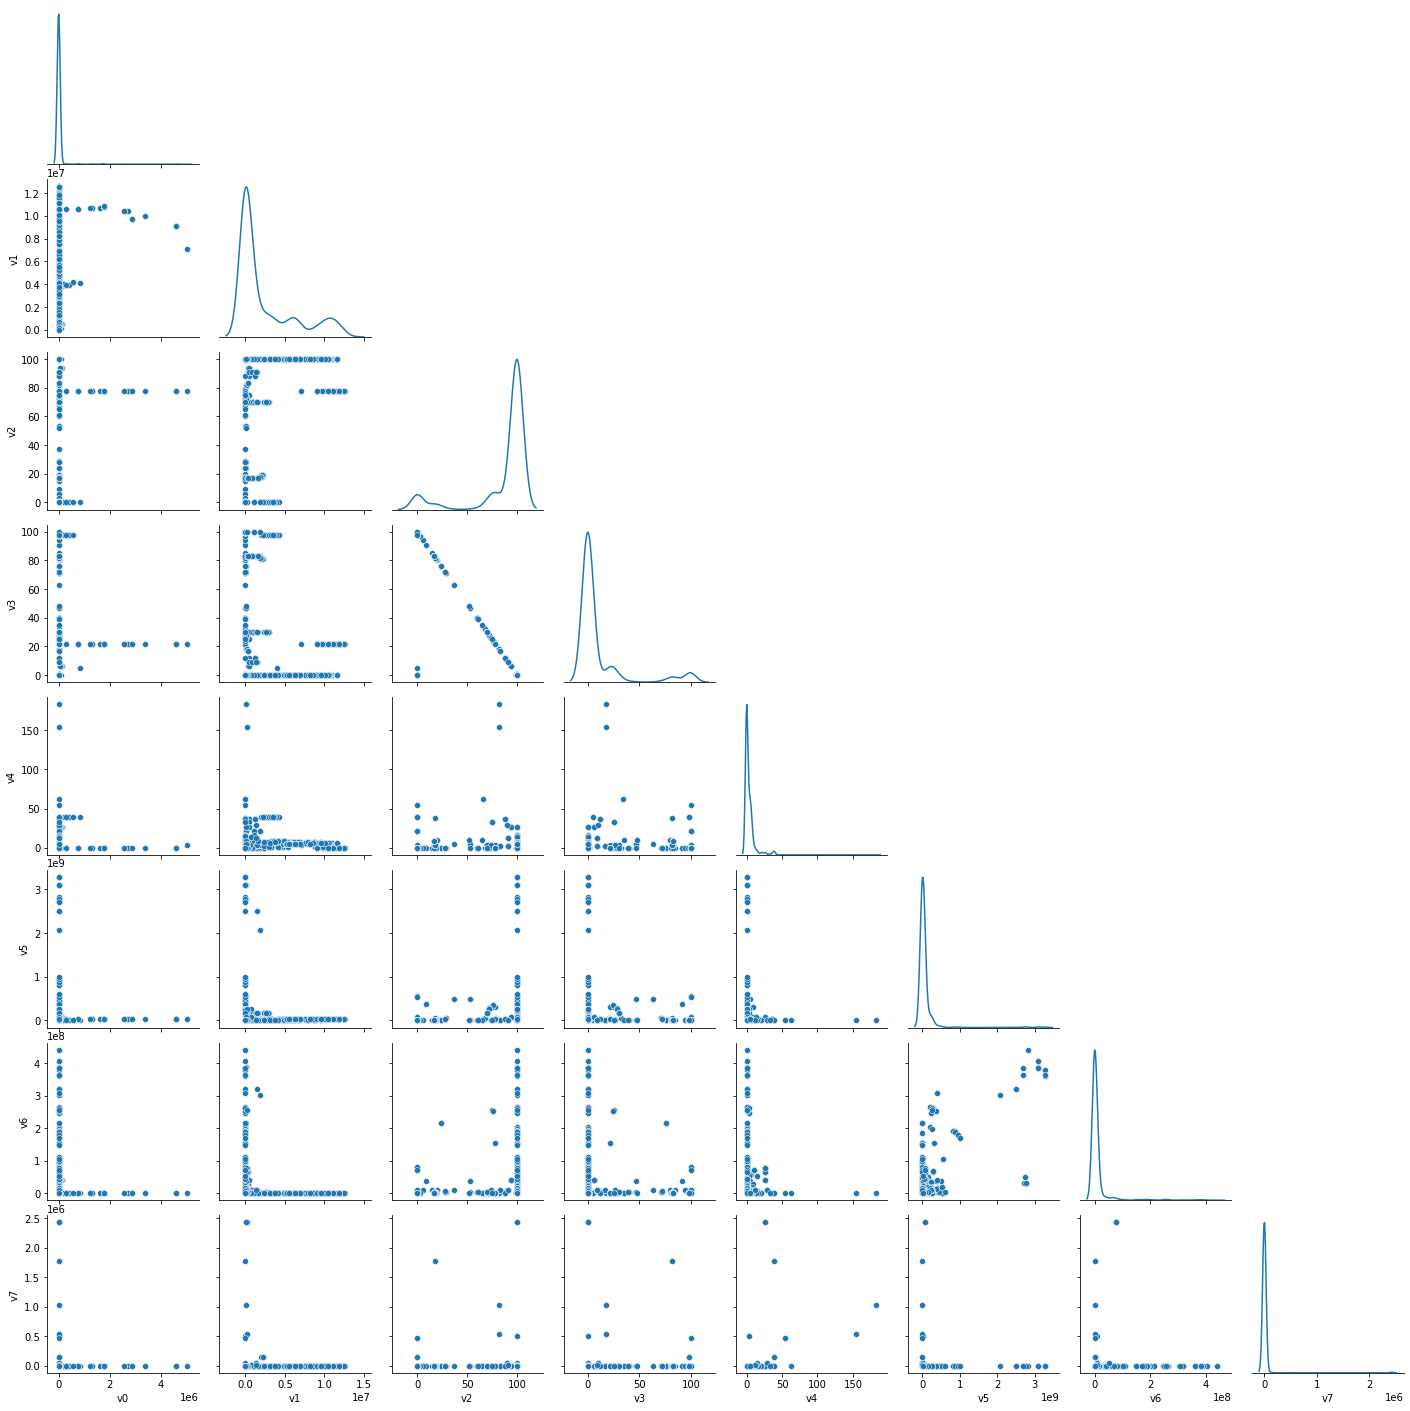

In [45]:
g = sns.PairGrid(db[lista_continuas[0:8]], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

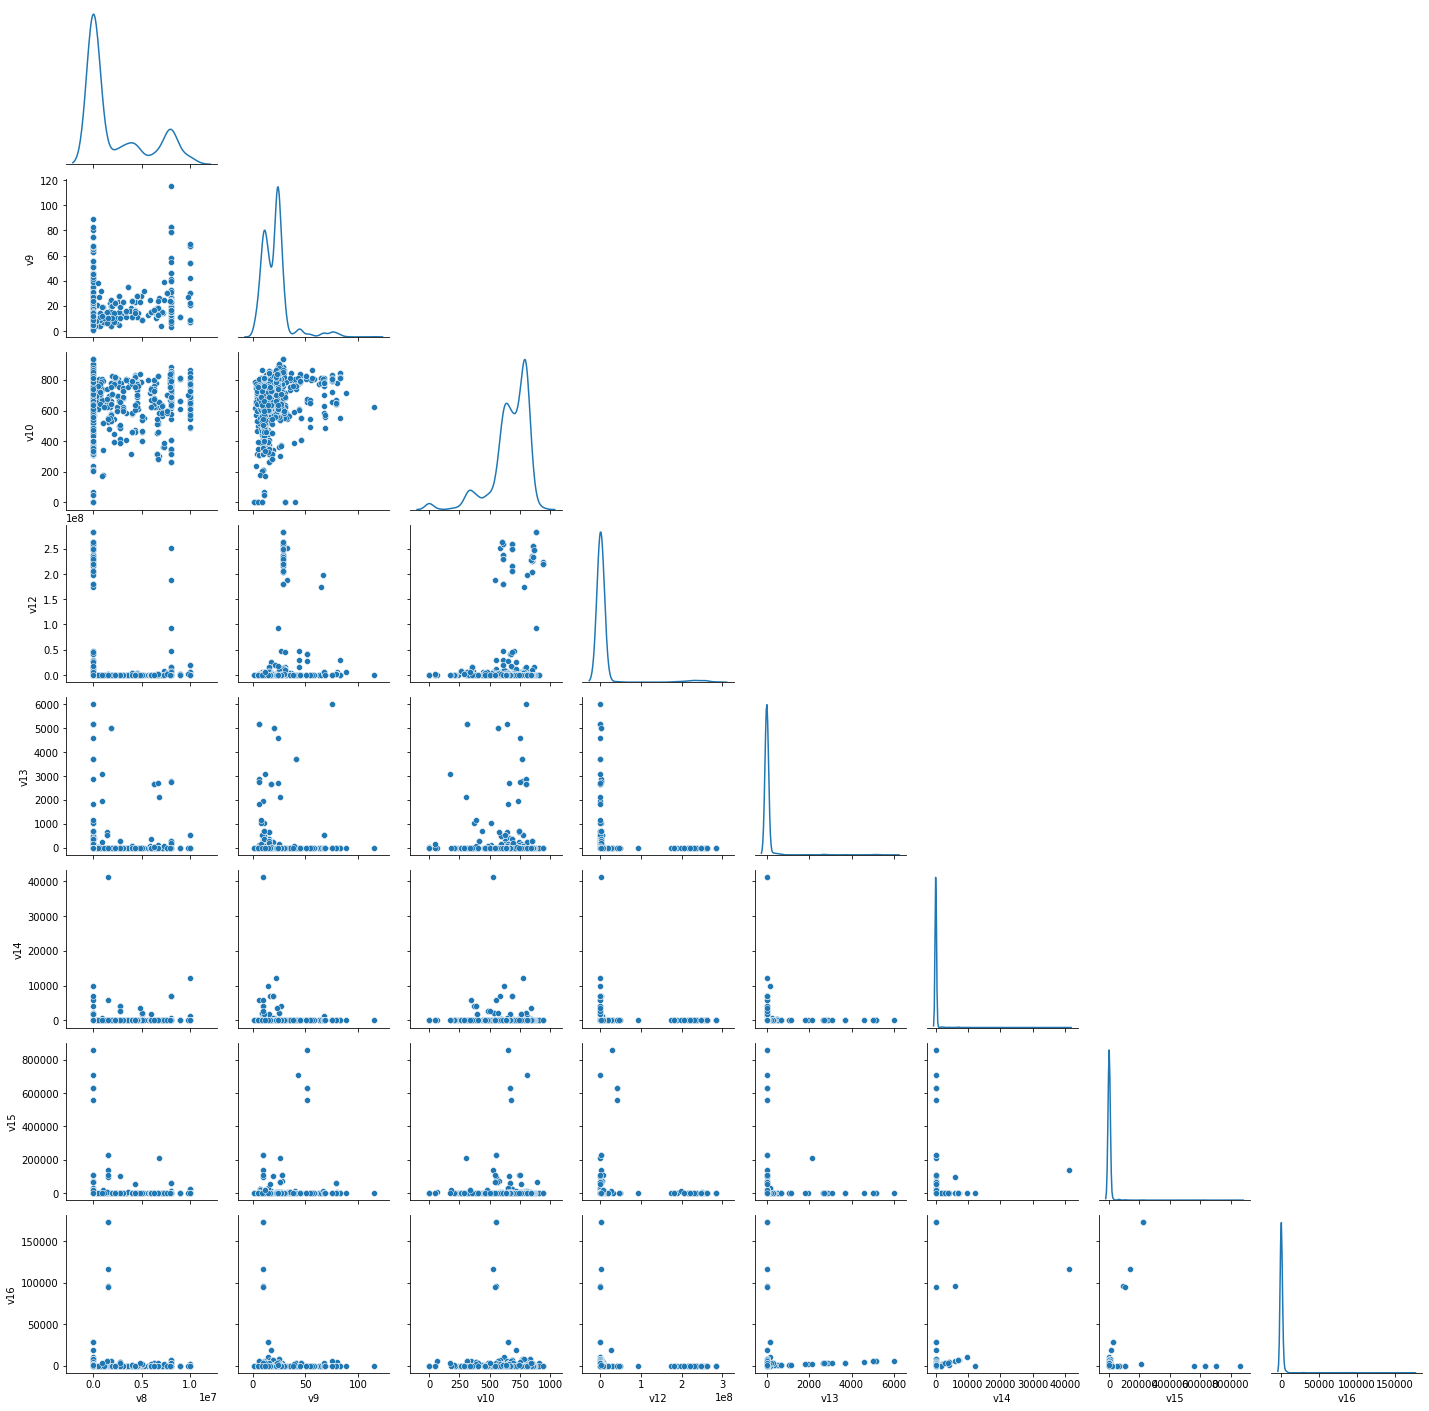

In [46]:
g = sns.PairGrid(db[lista_continuas[8:16]], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

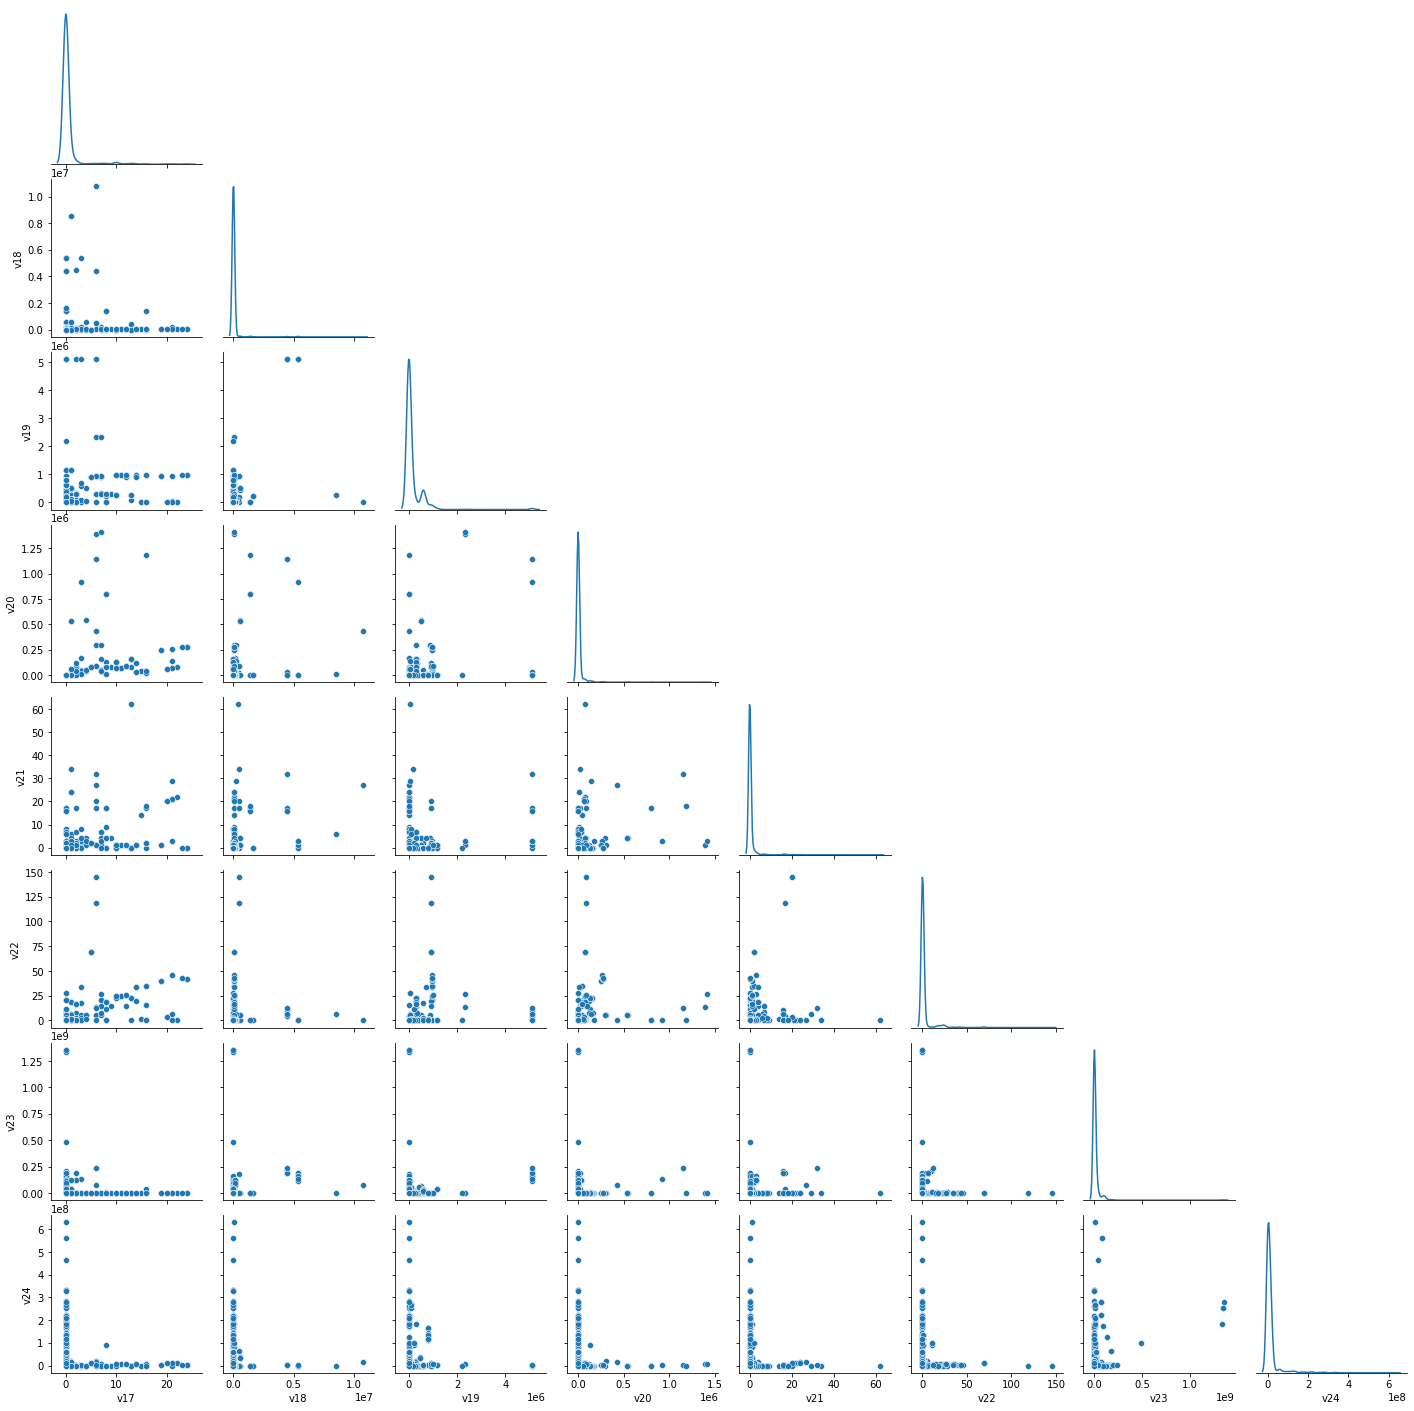

In [47]:
g = sns.PairGrid(db[lista_continuas[16:24]], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

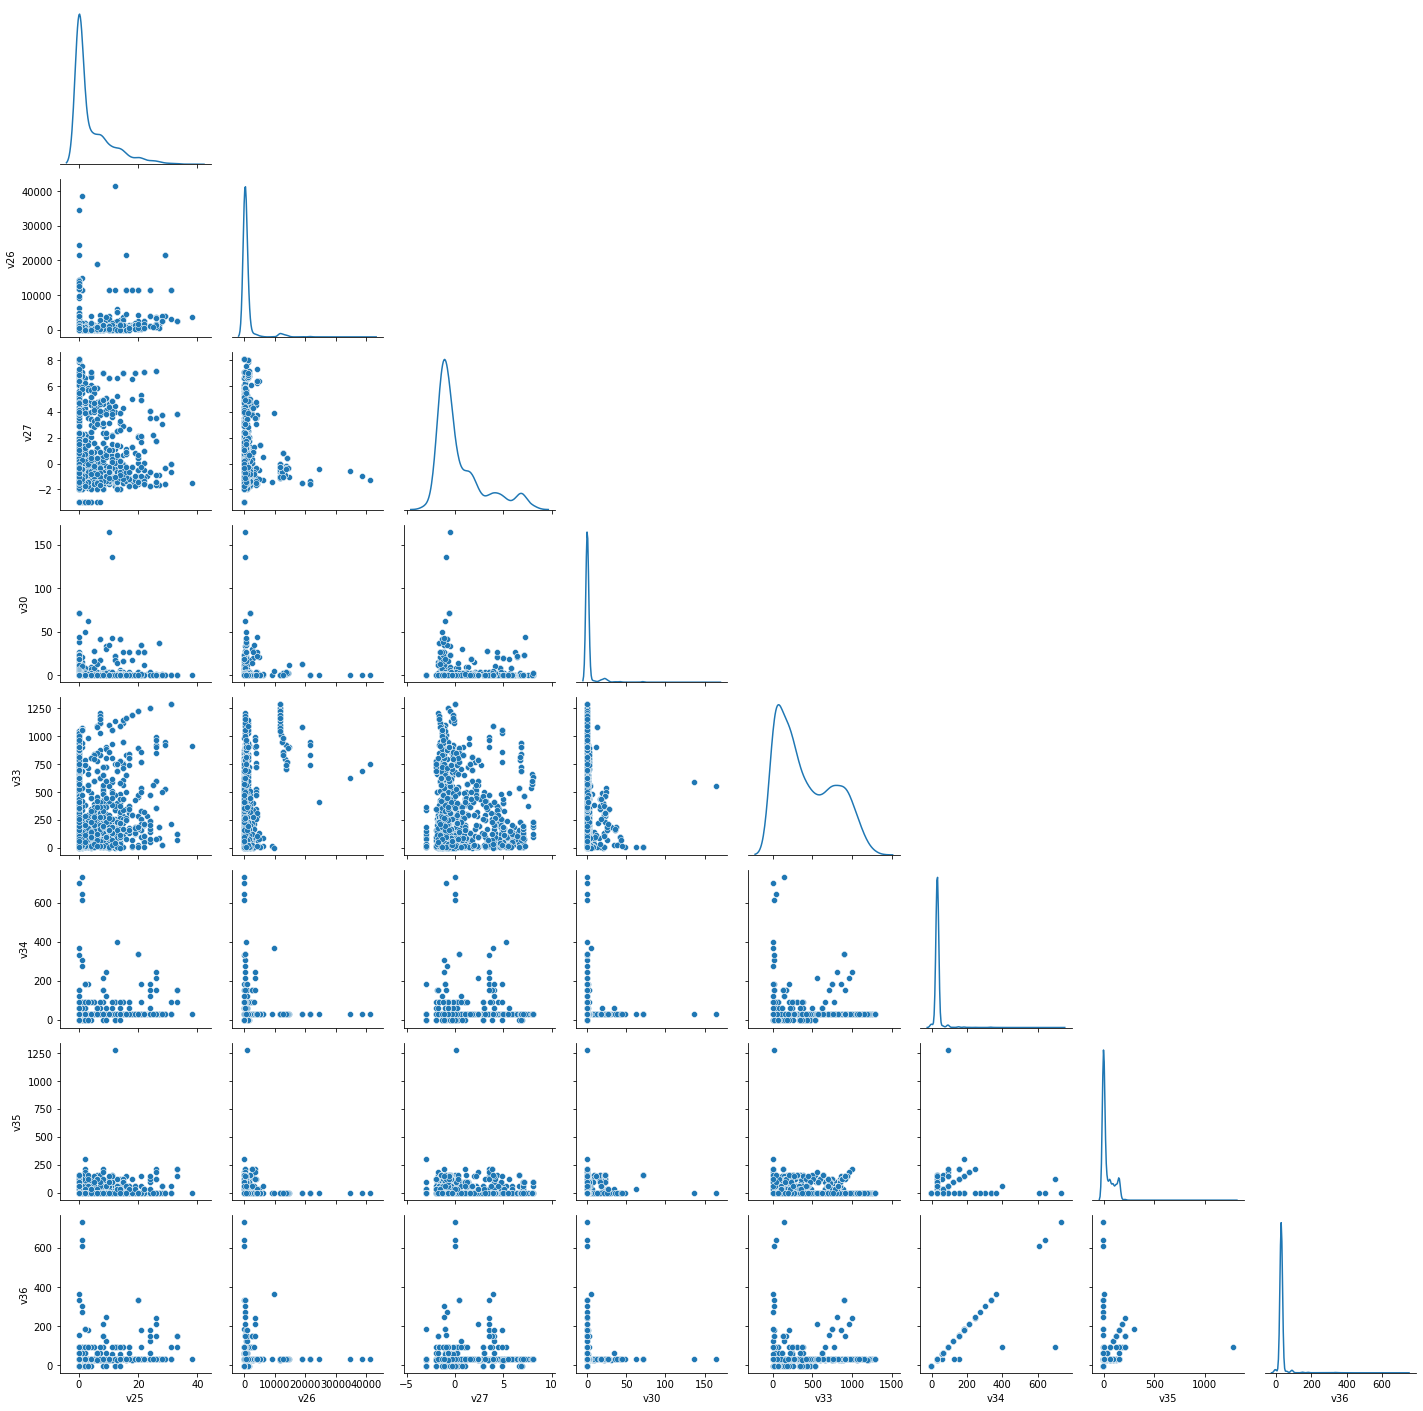

In [48]:
g = sns.PairGrid(db[lista_continuas[24:33]], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

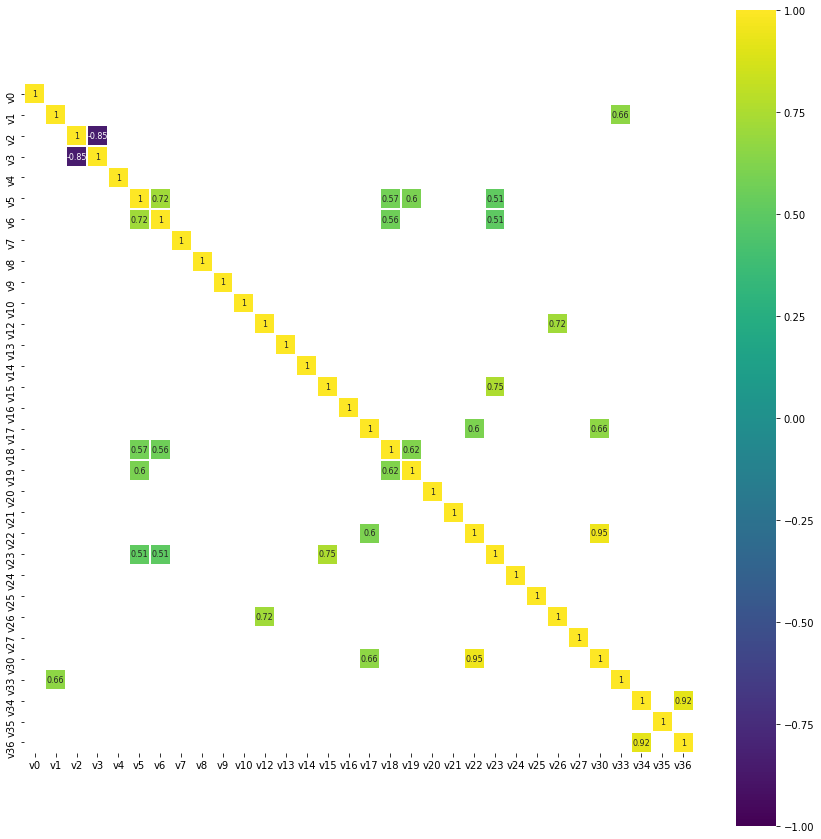

In [49]:
corr = db[lista_continuas].corr() # We already examined SalePrice correlations
plt.figure(figsize=(15, 15))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Las variables con altas correlaciones forman multicolinealidad, esto complica la convergencia de algunos algoritmos. La solución es eliminar alguna de dichas variables.

<AxesSubplot:xlabel='v33', ylabel='Count'>

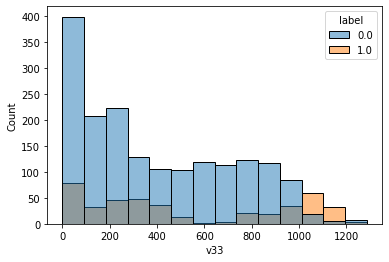

In [50]:
# Análisis variable discreta v33
sns.histplot(db,x='v33',hue='label')

Cantidad de outlier: 206
Media: 2498074.4664504337
Mediana: 178100.56
Q1: 14119.88
Q3: 3958600.59
max: 12570777.87


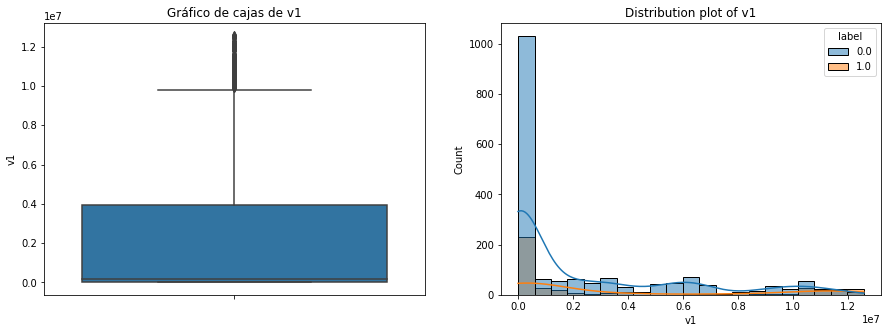

In [51]:
analisis_numerico(db,'v1','label')

<AxesSubplot:xlabel='label', ylabel='v1'>

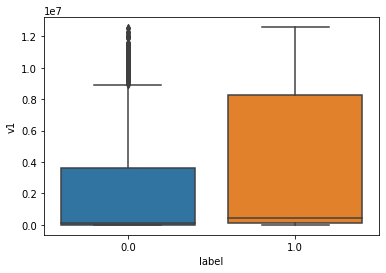

In [52]:
sns.boxplot(x="label", y="v1",data=db)

Cantidad de outlier: 451
Media: 10.317953403380539
Mediana: 0.0
Q1: 0.0
Q3: 0.0
max: 100.0


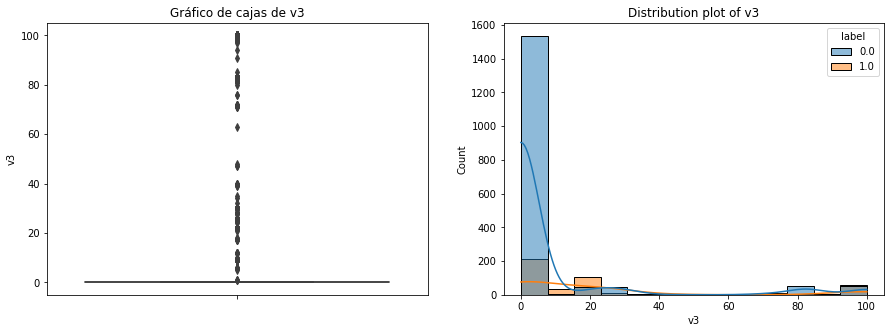

In [53]:
analisis_numerico(db,'v3','label')

Cantidad de outlier: 131
Media: 3.608040201005025
Mediana: 0.0
Q1: 0.0
Q3: 5.0
max: 183.0


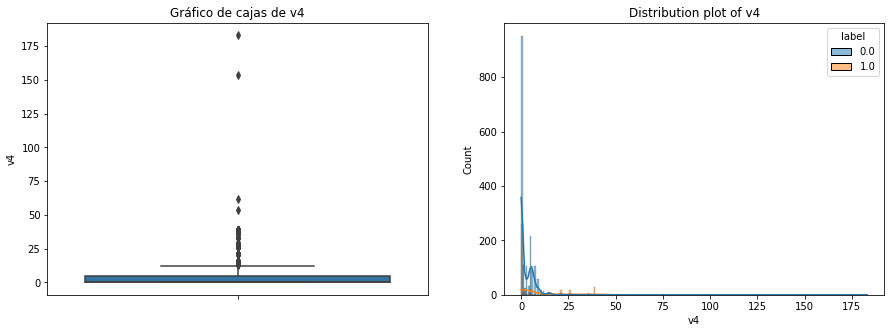

In [54]:
analisis_numerico(db,'v4','label')

Cantidad de outlier: 406
Media: 10110430.98321608
Mediana: 19704.6
Q1: 0.0
Q3: 2560790.58
max: 441531393.46


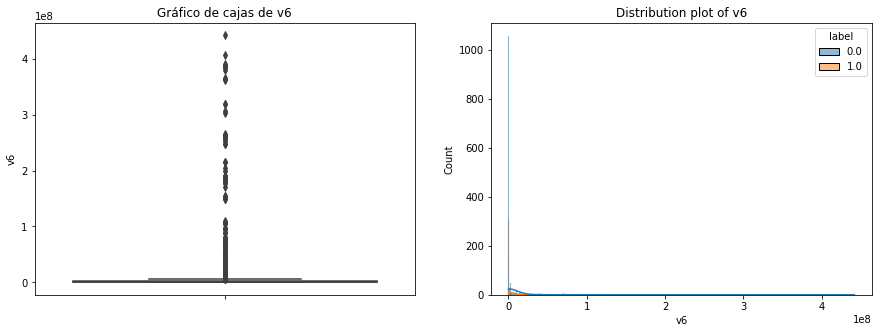

In [55]:
analisis_numerico(db,'v6','label')

Cantidad de outlier: 0
Media: 2283687.4658200094
Mediana: 0.0
Q1: 0.0
Q3: 4355600.0
max: 10000000.0


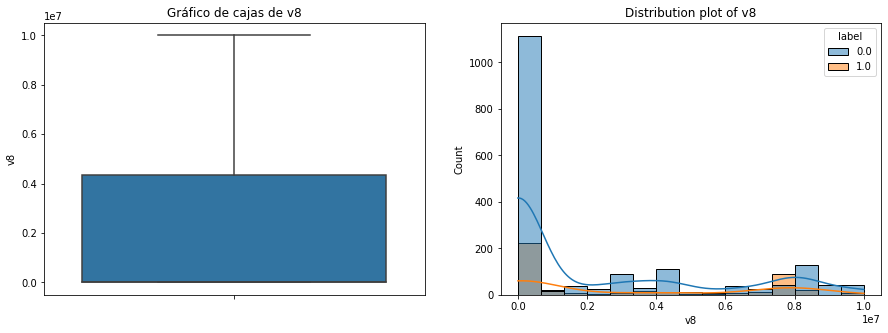

In [56]:
analisis_numerico(db,'v8','label')

<AxesSubplot:xlabel='label', ylabel='v8'>

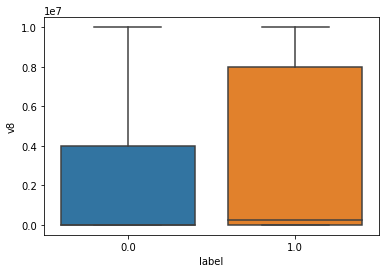

In [57]:
sns.boxplot(x="label", y="v8",data=db)

Cantidad de outlier: 125
Media: 20.920511649154864
Mediana: 22.0
Q1: 11.0
Q3: 24.0
max: 115.0


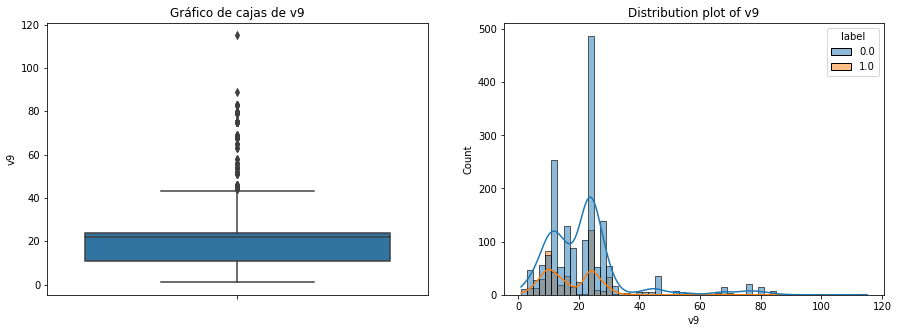

In [58]:
analisis_numerico(db,'v9','label')

Cantidad de outlier: 112
Media: 672.1269986295111
Mediana: 699.0
Q1: 610.0
Q3: 791.0
max: 936.0


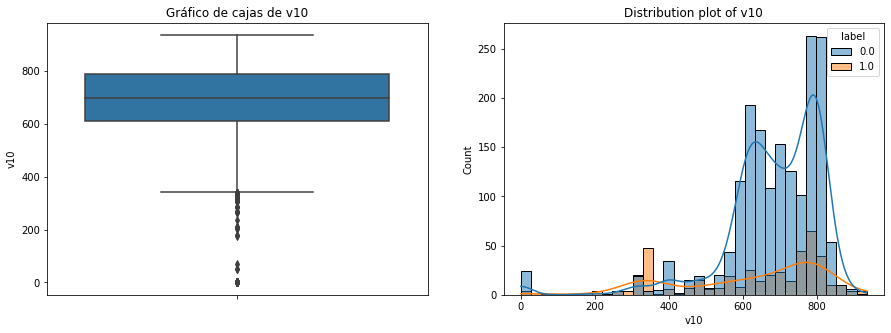

In [59]:
analisis_numerico(db,'v10','label')

Cantidad de outlier: 330
Media: 8800051.642110555
Mediana: 0.0
Q1: 0.0
Q3: 526941.6799999999
max: 283484419.52


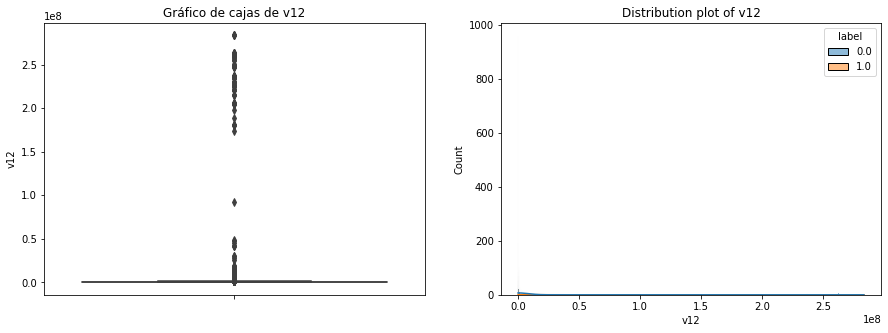

In [60]:
analisis_numerico(db,'v12','label')

Cantidad de outlier: 538
Media: 3090.8474189127455
Mediana: 0.0
Q1: 0.0
Q3: 0.0
max: 861279.0


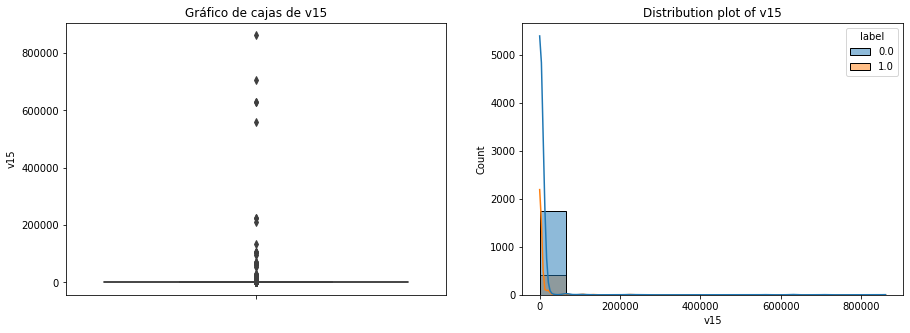

In [61]:
analisis_numerico(db,'v15','label')

Cantidad de outlier: 498
Media: 713.6742804933759
Mediana: 0.0
Q1: 0.0
Q3: 85.0
max: 173062.0


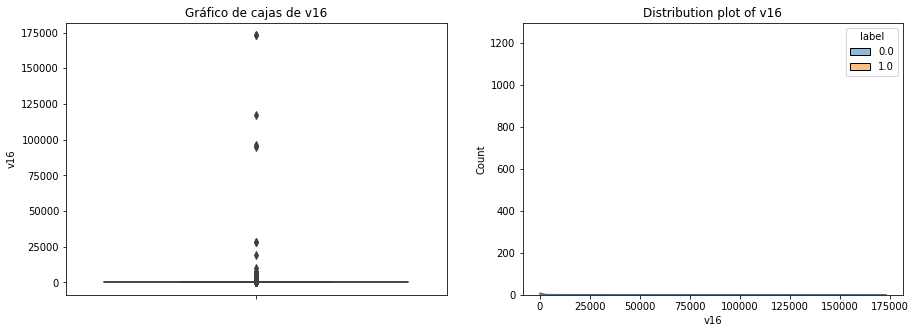

In [62]:
analisis_numerico(db,'v16','label')

Cantidad de outlier: 398
Media: 150292.41351301965
Mediana: 0.0
Q1: 0.0
Q3: 105000.0
max: 5117872.15


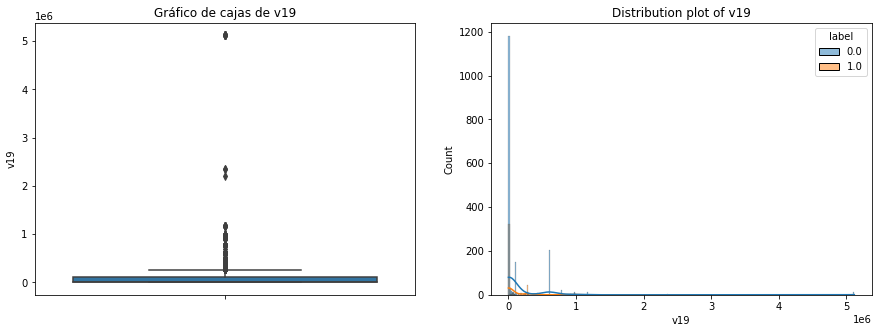

In [63]:
analisis_numerico(db,'v19','label')

Cantidad de outlier: 365
Media: 1.5778894472361809
Mediana: 0.0
Q1: 0.0
Q3: 0.0
max: 145.0


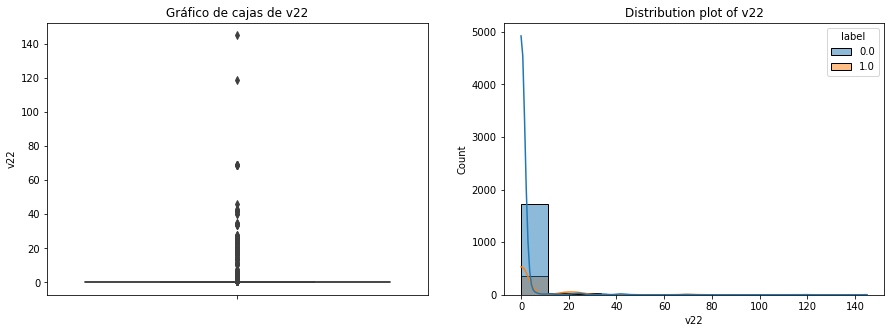

In [64]:
analisis_numerico(db,'v22','label')

Cantidad de outlier: 141
Media: 13449884.323977614
Mediana: 646617.05
Q1: 0.0
Q3: 13218157.6
max: 630195304.6009998


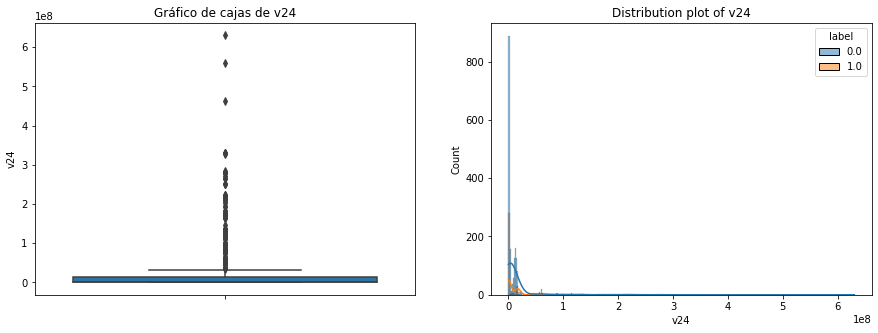

In [65]:
analisis_numerico(db,'v24','label')

Cantidad de outlier: 128
Media: 4.41388761991777
Mediana: 0.0
Q1: 0.0
Q3: 7.0
max: 38.0


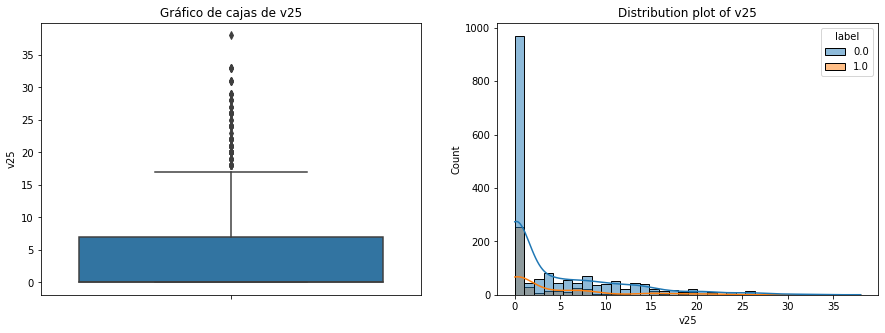

In [66]:
analisis_numerico(db,'v25','label')

<AxesSubplot:xlabel='label', ylabel='v26'>

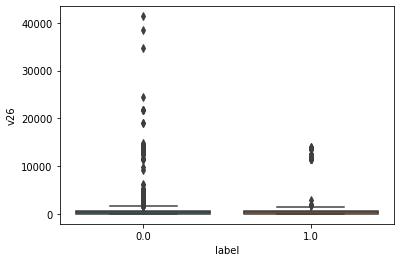

In [67]:
sns.boxplot(x="label", y="v26",data=db)

<AxesSubplot:xlabel='label', ylabel='v27'>

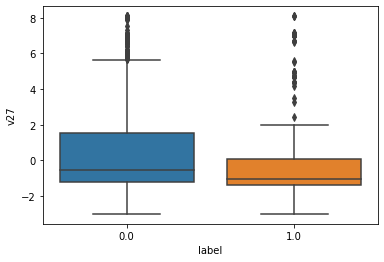

In [68]:
sns.boxplot(x="label", y="v27",data=db)

**CONCLUSIONES:**
* De la base, el 20% (aprox) son clientes morosos.
* No se tiene datos perdidos, ni duplicados.
* La variable discreta que tengan poca cantidad de etiquetas, posiblemente se trabaje como dummies.
* La variable discretas que tengan gran cantidad de etiquetas, posiblemente se trabaje con un target enconder.
* La variable d70, al ser una constante, es mejor eliminarlo.
* Las variables continuas con alto correlaciones, posiblemente deberían ser eliminadas.
* Las variables continuas que contengan más información de un solo valor, posiblemente deberían ser eliminadas o agrupadas para conservar alguna información.
* Existe presencia de outliers para ciertas variables continuas, posiblemente haremos una inputación por percentiles.


<a name="id4"></a><h1><center>PREPARACIÓN DE LOS DATOS</center></h1> 

<a name="id4.1"></a> <h3>TRATAMIENTO VARIABLES DISCRETAS</h3>

In [69]:
# Agrupamos algunas variables (presenta un valor repetido en la mayoría de resgistros)
# v0,v7,v13,v14,v17,v18,v20,v21,v2
db['v0_ag']=np.where(db.v0==0,0,np.where(db.v0>0,1,np.nan))
db['v7_ag']=np.where(db.v7==0,0,np.where(db.v7>0,1,np.nan))
db['v13_ag']=np.where(db.v13==0,0,np.where(db.v13>0,1,np.nan))
db['v14_ag']=np.where(db.v14==0,0,np.where(db.v14>0,1,np.nan))
db['v17_ag']=np.where(db.v17==0,0,np.where(db.v17>0,1,np.nan))
db['v18_ag']=np.where(db.v18==0,0,np.where(db.v18>0,1,np.nan))
db['v20_ag']=np.where(db.v20==0,0,np.where(db.v20>0,1,np.nan))
db['v21_ag']=np.where(db.v21==0,0,np.where(db.v21>0,1,np.nan))
db['v2_ag']=np.where(db.v2==100,0,np.where(db.v2<100,1,np.nan))

X_test['v0_ag']=np.where(X_test.v0==0,0,np.where(X_test.v0>0,1,np.nan))
X_test['v7_ag']=np.where(X_test.v7==0,0,np.where(X_test.v7>0,1,np.nan))
X_test['v13_ag']=np.where(X_test.v13==0,0,np.where(X_test.v13>0,1,np.nan))
X_test['v14_ag']=np.where(X_test.v14==0,0,np.where(X_test.v14>0,1,np.nan))
X_test['v17_ag']=np.where(X_test.v17==0,0,np.where(X_test.v17>0,1,np.nan))
X_test['v18_ag']=np.where(X_test.v18==0,0,np.where(X_test.v18>0,1,np.nan))
X_test['v20_ag']=np.where(X_test.v20==0,0,np.where(X_test.v20>0,1,np.nan))
X_test['v21_ag']=np.where(X_test.v21==0,0,np.where(X_test.v21>0,1,np.nan))
X_test['v2_ag']=np.where(X_test.v2==100,0,np.where(X_test.v2<100,1,np.nan))

In [70]:
# Target Encoding
# discreta3,discreta2,discreta1,v11,v28,v29,v31,v32
for i in ['discreta1','discreta2','discreta3','v11','v28','v29','v31','v32']:
    target_encoder(db,i,'label',X_test)

In [71]:
db.columns

Index(['id', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'tcs37', 'tcs38', 'tcs39',
       'tcs40', 'tcs41', 'tcs42', 'tc43', 'tc44', 'tc45', 'tc46', 'tc47',
       'tc48', 'tc49', 'tc50', 'tc51', 'tc52', 'tc53', 'dv54', 'ae55', 'ae56',
       'ae57', 'ae58', 'ae59', 'ae60', 'ae61', 'ae62', 'ae63', 'ae64', 'ae65',
       'ae66', 'ae67', 'ae68', 'd69', 'd70', 'label', 'discreta1', 'discreta2',
       'discreta3', 'v0_ag', 'v7_ag', 'v13_ag', 'v14_ag', 'v17_ag', 'v18_ag',
       'v20_ag', 'v21_ag', 'v2_ag', 'discreta1_tg', 'discreta2_tg',
       'discreta3_tg', 'v11_tg', 'v28_tg', 'v29_tg', 'v31_tg', 'v32_tg'],
      dtype='object')

In [72]:
X_test.columns

Index(['id', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'tcs37', 'tcs38', 'tcs39',
       'tcs40', 'tcs41', 'tcs42', 'tc43', 'tc44', 'tc45', 'tc46', 'tc47',
       'tc48', 'tc49', 'tc50', 'tc51', 'tc52', 'tc53', 'dv54', 'ae55', 'ae56',
       'ae57', 'ae58', 'ae59', 'ae60', 'ae61', 'ae62', 'ae63', 'ae64', 'ae65',
       'ae66', 'ae67', 'ae68', 'd69', 'd70', 'discreta1', 'discreta2',
       'discreta3', 'v0_ag', 'v7_ag', 'v13_ag', 'v14_ag', 'v17_ag', 'v18_ag',
       'v20_ag', 'v21_ag', 'v2_ag', 'discreta1_tg', 'discreta2_tg',
       'discreta3_tg', 'v11_tg', 'v28_tg', 'v29_tg', 'v31_tg', 'v32_tg'],
      dtype='object')

<a name="id4.2"></a> <h3>TRATAMIENTO VARIABLES CONTINUAS</h3>

In [73]:
lista_outliers=[
 'v1', 'v3', 'v4', 'v5', 'v6', 'v8', 'v9', 'v10', 'v12','v15', 'v16',
 'v19', 'v22', 'v23', 'v24',
 'v25', 'v26', 'v27', 'v30', 'v33', 'v34', 'v35', 'v36']

In [74]:
# verificamos su correlaciones

def topcorrelaciones(data, top):
    cormatrix = data.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["Variable 1", "Variable 2", "correlación"]
    return cormatrix.head(top)


topcorrelaciones(db[lista_outliers], 10)
# topcorrelaciones(db[var_num].drop('ID',axis=1), 6)

,Variable 1,Variable 2,correlación
0,v22,v30,0.947241
1,v34,v36,0.915696
2,v15,v23,0.754541
3,v12,v26,0.716354
4,v5,v6,0.716031
5,v1,v33,0.661862
6,v5,v19,0.599873
7,v5,v23,0.511030
8,v6,v23,0.505048
9,v6,v19,0.497139


<font color=blue> OJO: Se recomienda eliminar las variables numéricas que estan más asociadas con otros (v30,v36,v23,v26,v6).</font>

<a name="id4.3"></a> <h3>TRANSFORMACIÓN WOE</h3>

El cálculo del WOE se realiza con la base train, y dicha agrupación se replica directo a la base test

In [75]:
lista_woe_con=[
 'v1', 'v3', 'v4', 'v5', 'v6', 'v8', 'v9', 'v10', 'v12','v15', 'v16',
 'v19', 'v22', 'v23', 'v24',
 'v25', 'v26', 'v27', 'v30', 'v33', 'v34', 'v35', 'v36']

In [76]:
for i in lista_woe_con:
    mapwoe_num(db,i,X_test)

In [77]:
# v0_ag,v7_ag,v13_ag,v14_ag,v17_ag,v18_ag,v20_ag,v21_ag,v2_ag
# lista_woe_cat=['v0','v7','v13','v14','v17','v18','v20','v21','v2','discreta1', 'discreta2',
#        'discreta3']
lista_woe_cat=['v0_ag','v2_ag','v7_ag','v11','v13_ag','v14_ag','v17_ag','v18_ag','v20_ag','v21_ag','discreta1', 'discreta2',
       'discreta3','v28','v29','v31','v32']

In [78]:
for i in lista_woe_cat:
    mapwoe_cat(db,i,X_test)

In [79]:
db.columns[70:]

Index(['d69', 'd70', 'label', 'discreta1', 'discreta2', 'discreta3', 'v0_ag',
       'v7_ag', 'v13_ag', 'v14_ag', 'v17_ag', 'v18_ag', 'v20_ag', 'v21_ag',
       'v2_ag', 'discreta1_tg', 'discreta2_tg', 'discreta3_tg', 'v11_tg',
       'v28_tg', 'v29_tg', 'v31_tg', 'v32_tg', 'v1_woe', 'v3_woe', 'v4_woe',
       'v5_woe', 'v6_woe', 'v8_woe', 'v9_woe', 'v10_woe', 'v12_woe', 'v15_woe',
       'v16_woe', 'v19_woe', 'v22_woe', 'v23_woe', 'v24_woe', 'v25_woe',
       'v26_woe', 'v27_woe', 'v30_woe', 'v33_woe', 'v34_woe', 'v35_woe',
       'v36_woe', 'bin', 'v0_ag_woe', 'v2_ag_woe', 'v7_ag_woe', 'v11_woe',
       'v13_ag_woe', 'v14_ag_woe', 'v17_ag_woe', 'v18_ag_woe', 'v20_ag_woe',
       'v21_ag_woe', 'discreta1_woe', 'discreta2_woe', 'discreta3_woe',
       'v28_woe', 'v29_woe', 'v31_woe', 'v32_woe'],
      dtype='object')

In [80]:
X_test.columns[70:]

Index(['d69', 'd70', 'discreta1', 'discreta2', 'discreta3', 'v0_ag', 'v7_ag',
       'v13_ag', 'v14_ag', 'v17_ag', 'v18_ag', 'v20_ag', 'v21_ag', 'v2_ag',
       'discreta1_tg', 'discreta2_tg', 'discreta3_tg', 'v11_tg', 'v28_tg',
       'v29_tg', 'v31_tg', 'v32_tg', 'v1_woe', 'v3_woe', 'v4_woe', 'v5_woe',
       'v6_woe', 'v8_woe', 'v9_woe', 'v10_woe', 'v12_woe', 'v15_woe',
       'v16_woe', 'v19_woe', 'v22_woe', 'v23_woe', 'v24_woe', 'v25_woe',
       'v26_woe', 'v27_woe', 'v30_woe', 'v33_woe', 'v34_woe', 'v35_woe',
       'v36_woe', 'v0_ag_woe', 'v2_ag_woe', 'v7_ag_woe', 'v11_woe',
       'v13_ag_woe', 'v14_ag_woe', 'v17_ag_woe', 'v18_ag_woe', 'v20_ag_woe',
       'v21_ag_woe', 'discreta1_woe', 'discreta2_woe', 'discreta3_woe',
       'v28_woe', 'v29_woe', 'v31_woe', 'v32_woe'],
      dtype='object')

<a name="id4.4"></a> <h3>TRATAMIENTO OUTLIERS</h3>

In [81]:
lista_outliers=[
 'v1', 'v3', 'v4', 'v5', 'v6', 'v8', 'v9', 'v10', 'v12','v15', 'v16',
 'v19', 'v22', 'v23', 'v24',
 'v25', 'v26', 'v27', 'v30', 'v33', 'v34', 'v35', 'v36']

In [82]:
for i in lista_outliers:
    trat_outliers(db,i)

<a name="id4.5"></a> <h3>ESCALAMIENTO</h3>

In [83]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# normalizar y/o escalar
# features=list(db.columns)
lista_outliers=[
 'v1', 'v3', 'v4', 'v5', 'v6', 'v8', 'v9', 'v10', 'v12','v15', 'v16',
 'v19', 'v22', 'v23', 'v24',
 'v25', 'v26', 'v27', 'v30', 'v33', 'v34', 'v35', 'v36']

X = db[lista_outliers]
y = db.label

std_scale_train = preprocessing.StandardScaler().fit(X)
db[lista_outliers] = std_scale_train.transform(X)

In [84]:
db[lista_outliers].describe([0.1,0.25,0.5,0.75,0.85,0.9,0.95,0.98])

,v1,v3,v4,v5,v6,v8,v9,v10,v12,v15,...,v23,v24,v25,v26,v27,v30,v33,v34,v35,v36
count,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,...,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03,2.189000e+03
mean,-8.926416e-17,-2.434477e-17,7.465730e-17,1.622985e-17,7.465730e-17,-2.596776e-17,1.103630e-16,9.713564e-16,5.355850e-17,5.842745e-17,...,-2.475052e-17,6.978835e-17,1.947582e-17,-2.272179e-17,4.868954e-18,8.439521e-17,7.709178e-17,1.588902e-15,1.136089e-16,1.846145e-16
std,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,...,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00,1.000228e+00
min,-6.937927e-01,-4.866779e-01,-7.507445e-01,-7.400968e-01,-5.529711e-01,-7.044528e-01,-1.440359e+00,-1.917171e+00,-5.566440e-01,-5.391721e-01,...,-5.225730e-01,-8.193449e-01,-7.574934e-01,-9.799609e-01,-9.103289e-01,-4.916501e-01,-1.212153e+00,-2.099088e+00,-6.743227e-01,-2.092814e+00
10%,-6.937927e-01,-4.866779e-01,-7.507445e-01,-7.400918e-01,-5.529711e-01,-7.044528e-01,-1.440359e+00,-1.911119e+00,-5.566440e-01,-5.391721e-01,...,-5.225730e-01,-8.193449e-01,-7.574934e-01,-9.799609e-01,-9.103289e-01,-4.916501e-01,-1.212153e+00,-2.099088e+00,-6.743227e-01,-2.092814e+00
25%,-6.896500e-01,-4.866779e-01,-7.507445e-01,-6.748571e-01,-5.529711e-01,-7.044528e-01,-1.156961e+00,-7.276299e-01,-5.566440e-01,-5.391721e-01,...,-5.207367e-01,-8.193449e-01,-7.574934e-01,-9.204562e-01,-7.842091e-01,-4.916501e-01,-8.977040e-01,-6.809080e-01,-6.743227e-01,-6.771251e-01
50%,-6.415392e-01,-4.866779e-01,-7.507445e-01,-3.722905e-01,-5.488787e-01,-7.044528e-01,4.017287e-01,1.139371e-01,-5.566440e-01,-5.391721e-01,...,-5.133045e-01,-7.274723e-01,-7.574934e-01,-2.813313e-01,-4.536084e-01,-4.916501e-01,-2.749720e-01,7.372724e-01,-6.743227e-01,7.385643e-01
75%,4.676329e-01,-4.866779e-01,8.054863e-01,1.022413e-02,-2.112936e-02,6.783841e-01,6.851268e-01,9.838716e-01,-5.110754e-02,-5.391721e-01,...,-1.993719e-01,1.058715e+00,6.266076e-01,4.900263e-01,5.502821e-01,-4.916501e-01,9.581608e-01,7.372724e-01,6.391604e-01,7.385643e-01
85%,1.280657e+00,1.614015e+00,1.427979e+00,8.875448e-01,1.381048e+00,1.826799e+00,1.110224e+00,1.097341e+00,8.892689e-01,1.980993e+00,...,1.489366e+00,1.440290e+00,1.417522e+00,1.322211e+00,1.402701e+00,9.510069e-01,1.429834e+00,7.372724e-01,1.909579e+00,7.385643e-01
90%,2.149519e+00,2.377904e+00,2.050471e+00,2.617695e+00,2.445279e+00,1.835426e+00,1.393622e+00,1.135165e+00,2.532526e+00,1.980993e+00,...,2.420648e+00,1.699568e+00,2.010709e+00,2.061392e+00,2.139966e+00,2.393664e+00,1.617887e+00,7.372724e-01,1.953505e+00,7.385643e-01


<a name="id4.6"></a> <h3>DESBALANCE DEL TARGET</h3>

Al tener una tasa del 20% de casos con morosidad, se optó por trabajar con toda las base, no hay una regla que nos diga cuando aplicar los métodos de undersampling, oversampling o smote, considero que es necesario aplicarlo cuando la tasa no supere el 5% o 10%

<a name="id4.7"></a> <h3>SELECCIÓN DE VARIABLES</h3>

Seleccionar previamente algunas variable para entrenar el modelo nos ayudará a evitar el sobreajuste, existen muchos métodos, aqui provamos el RFM y vemos que variables el top10 de variables más relevantes.

In [85]:
var_woe=['v1_woe', 'v3_woe', 'v4_woe',
       'v5_woe', 'v6_woe', 'v8_woe', 'v9_woe', 'v10_woe', 'v12_woe', 'v15_woe',
       'v16_woe', 'v19_woe', 'v22_woe', 'v23_woe', 'v24_woe', 'v25_woe',
       'v26_woe', 'v27_woe', 'v30_woe', 'v33_woe', 'v34_woe', 'v35_woe',
       'v36_woe', 'v0_ag_woe', 'v2_ag_woe', 'v7_ag_woe', 'v11_woe',
       'v13_ag_woe', 'v14_ag_woe', 'v17_ag_woe', 'v18_ag_woe', 'v20_ag_woe',
       'v21_ag_woe', 'discreta1_woe', 'discreta2_woe', 'discreta3_woe',
       'v28_woe', 'v29_woe', 'v31_woe', 'v32_woe']

In [86]:
var_1=['v1', 'v3', 'v4', 'v5', 'v6', 'v8', 'v9', 'v10', 'v12','v15', 'v16', 'v19', 
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v30', 'v33', 'v34', 'v35', 'v36',
       'v0_ag','v2_ag', 'v7_ag','v13_ag', 'v14_ag', 'v17_ag', 'v18_ag', 'v20_ag', 'v21_ag',
       'discreta1_tg', 'discreta2_tg', 'discreta3_tg','v11','v28','v29','v31','v32']

In [87]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

rfe_lr=RFE(lr,10)
rfe_lr=rfe_lr.fit(db[var_woe],db['label'])

feature_lr=pd.DataFrame({'variable':var_woe,'support':rfe_lr.support_,'ranking':rfe_lr.ranking_})
var_lr_woe=feature_lr[feature_lr.ranking==1].variable.tolist()
var_lr_woe

['v1_woe',
 'v16_woe',
 'v23_woe',
 'v24_woe',
 'v27_woe',
 'v2_ag_woe',
 'v11_woe',
 'v18_ag_woe',
 'discreta2_woe',
 'discreta3_woe']

In [88]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

rfe_dt=RFE(dt,10)
rfe_dt=rfe_dt.fit(db[var_woe],db['label'])

feature_dt=pd.DataFrame({'variable':var_woe,'support':rfe_dt.support_,'ranking':rfe_dt.ranking_})
var_dt_woe=feature_dt[feature_dt.ranking==1].variable.tolist()
var_dt_woe

['v1_woe',
 'v8_woe',
 'v16_woe',
 'v23_woe',
 'v24_woe',
 'v27_woe',
 'v33_woe',
 'v2_ag_woe',
 'discreta1_woe',
 'discreta3_woe']

In [89]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

rfe_lr=RFE(lr,10)
rfe_lr=rfe_lr.fit(db[var_1],db['label'])

feature_lr=pd.DataFrame({'variable':var_1,'support':rfe_lr.support_,'ranking':rfe_lr.ranking_})
var_lr=feature_lr[feature_lr.ranking==1].variable.tolist()
var_lr

['v12',
 'v23',
 'v27',
 'v0_ag',
 'v2_ag',
 'v7_ag',
 'v18_ag',
 'discreta1_tg',
 'discreta2_tg',
 'discreta3_tg']

In [90]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

rfe_dt=RFE(dt,10)
rfe_dt=rfe_dt.fit(db[var_1],db['label'])

feature_dt=pd.DataFrame({'variable':var_1,'support':rfe_dt.support_,'ranking':rfe_dt.ranking_})
var_dt=feature_dt[feature_dt.ranking==1].variable.tolist()
var_dt

['v1',
 'v3',
 'v5',
 'v10',
 'v24',
 'v26',
 'v27',
 'v35',
 'discreta1_tg',
 'discreta3_tg']

<a name="id4.8"></a> <h3>PARTICIÓN DEL TRAIN Y TEST</h3>

Creamos los grupos de train y test, con el cual ajustaremos el modelo y luego predecir.

In [91]:
X_train_woe=db[var_woe]
y_train_woe=db['label']

X_train=db[var_1]
y_train=db['label']

X_test_woe=X_test[var_woe]
y_test_woe=y_test['label']

X_test=X_test[var_1]
y_test=y_test['label']

<a name="id5"></a><h1><center>MODELAMIENTO</center></h1> 

<a name="id5.1"></a> <h3>OPTIMIZACIÓN DE HIPERPARÁMETROS</h3>

Este método nos permite encontrar los hiperparámetros más óptimos para cada modelo, esto con el fin de no tomar de manera manual los hiperparámetros y evitarnos hacer varias pruebas.

In [ ]:
# [No correr directo]
# Dependiendo del grupo de variables a entrenar, iremos habilitan las siguientes lineas:

# X=X_train_woe
# y=y_train_woe

X=X_train
y=y_train

Regresión Logística

In [66]:
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

dic_param= {'max_iter':[10,50,100,200,500,1000],
            'tol':[.001,.005,.01],
            'random_state' : [11,42,123]}
# Creamos el grid search 
grid  = GridSearchCV(estimator = lm.LogisticRegression(class_weight="balanced"), param_grid=dic_param,
                     cv = 3)

# Ahora viene el GYM :
import time
start = time.time()
grid_result = grid.fit(X,y)
print("Tiempo de procesamiento: "  + str(time.time() - start))

print("Mejor score : %f Usando : %s" %(grid_result.best_score_,grid_result.best_params_))

Tiempo de procesamiento: 18.402326107025146
Mejor score : 0.837373 Usando : {'max_iter': 500, 'random_state': 11, 'tol': 0.001}


Modelo ElasticNET

In [67]:
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

dic_param= {'max_iter':[10,50,100,200,500,1000],
            'C':[.25,.3,.35,.4],
            'l1_ratio':[.9,.99,.999],
            'random_state' : [11,42,123]}
# Creamos el grid search 
grid  = GridSearchCV(estimator = lm.LogisticRegression(penalty = 'elasticnet',class_weight = "balanced",solver = 'saga'), param_grid=dic_param,
                     cv = 3)

# Ahora viene el GYM :
import time 
start = time.time()
grid_result = grid.fit(X,y)
print("Tiempo de procesamiento: "  + str(time.time() - start))

print("Mejor score : %f Usando : %s" %(grid_result.best_score_,grid_result.best_params_))

Tiempo de procesamiento: 134.50523948669434
Mejor score : 0.804476 Usando : {'C': 0.4, 'l1_ratio': 0.9, 'max_iter': 1000, 'random_state': 11}


Arbol de Decisión

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

dic_param= {'max_depth':[10,50,100,200,500,1000],
            'min_samples_leaf':[.00001,.00005,.00015,.0001],
            'random_state' : [11,42,123]}
# Creamos el grid search 
grid  = GridSearchCV(estimator = DecisionTreeClassifier(class_weight = {0:y.mean(),1:1}), param_grid=dic_param,
                     cv = 3)

# Ahora viene el GYM :
import time 
start = time.time()
grid_result = grid.fit(X,y)
print("Tiempo de procesamiento: "  + str(time.time() - start))
print("Mejor score : %f Usando : %s" %(grid_result.best_score_,grid_result.best_params_))

Tiempo de procesamiento: 2.061061143875122
Mejor score : 0.889446 Usando : {'max_depth': 50, 'min_samples_leaf': 1e-05, 'random_state': 11}


Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

dic_param= {'n_estimators' : [10,50,100,200,500],
            'max_depth':[45,50,55],
            'min_samples_leaf':[.000001,.00001],
            'random_state' : [11,42,123]}
# Creamos el grid search 
grid  = GridSearchCV(estimator = RandomForestClassifier(
                                            class_weight = {0:y_train.mean(),1:1},
                                            oob_score = True,
                                            verbose = 1,
                                            n_jobs = -1), param_grid=dic_param,cv = 3)

# Ahora viene el GYM :
import time 
start = time.time()
grid_result = grid.fit(X,y)
print("Tiempo de procesamiento: "  + str(time.time() - start))
print("Mejor score : %f Usando : %s" %(grid_result.best_score_,grid_result.best_params_))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s f

[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurr

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jo

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend Th

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Par

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elap

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of

Tiempo de procesamiento: 62.71698498725891
Mejor score : 0.898122 Usando : {'max_depth': 45, 'min_samples_leaf': 1e-06, 'n_estimators': 200, 'random_state': 11}


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished


Modelo Adaboost

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

dic_param= {'n_estimators' : [50,100,500,1000],
            # 'max_depth':[25,50,75],
            'learning_rate':[0.75,0.5,0.25,0.1],
            'random_state' : [11,42,123]}
# Creamos el grid search 
grid  = GridSearchCV(estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 6),algorithm = 'SAMME.R'), param_grid=dic_param,cv = 3)

# Ahora viene el GYM :
import time 
start = time.time()
grid_result = grid.fit(X,y)
print("Tiempo de procesamiento: "  + str(time.time() - start))
#max_depth = 6
print("Mejor score : %f Usando : %s" %(grid_result.best_score_,grid_result.best_params_))

Tiempo de procesamiento: 303.09970355033875
Mejor score : 0.905883 Usando : {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 11}


<a name="id5.2"></a> <h3>MODELOS BASES OPTIMIZADOS</h3>

Luego de encontrar los hiperparámetros más optimos, podemos ajustar nuestros modelos. Estos hiperparámetros ya están cargadas en mis funciones a modelar.

In [92]:
# ajustamos los modelos con variables VAR1
m_logistic1=m_logistico(db[var_1],db['label'])
m_elastic1=m_elastic(db[var_1],db['label'])
m_tree1=m_arbol(db[var_1],db['label'])
m_random1=m_random(db[var_1],db['label'])
m_ada=m_adaboost(db[var_1],db['label'])

# ajustamos los modelos con variables WOE
m_logistic1_woe=m_logistico_woe(db[var_woe],db['label'])
m_elastic1_woe=m_elastic_woe(db[var_woe],db['label'])
m_tree1_woe=m_arbol_woe(db[var_woe],db['label'])
m_random1_woe=m_random_woe(db[var_woe],db['label'])
m_ada_woe=m_adaboost_woe(db[var_woe],db['label'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


<a name="id5.3"></a> <h3>VARIABLES MÁS RELEVANTES DE LOS MODELOS</h3>

### MODELOS CON VARIABLES VAR1

In [93]:
paramLogistic = pd.DataFrame({'feature': X_train.columns.tolist(),
                              'parámetro': m_logistic1.coef_.ravel()})
print("modelo logistico")
paramLogistic=paramLogistic.sort_values('parámetro',ascending=False)
paramLogistic['exp']=np.exp(paramLogistic.parámetro)
paramLogistic['razon']=np.where(np.abs(paramLogistic.parámetro)>=1,np.exp(paramLogistic.parámetro),1/np.exp(paramLogistic.parámetro))
paramLogistic.sort_values('razon',ascending=False,).reset_index(drop=True).head(10)

modelo logistico


,feature,parámetro,exp,razon
0,discreta3_tg,5.122805,167.805468,167.805468
1,discreta2_tg,2.504932,12.242726,12.242726
2,v0_ag,2.337771,10.358124,10.358124
3,v21_ag,1.663921,5.279975,5.279975
4,v2_ag,1.211821,3.359598,3.359598
5,v18_ag,1.087584,2.967098,2.967098
6,v14_ag,-0.708033,0.492612,2.029995
7,v23,-0.695257,0.498946,2.004224
8,v27,-0.674544,0.509389,1.963138
9,v13_ag,-0.649327,0.522397,1.914252


In [102]:
paramElasticNet = pd.DataFrame({'feature': X_train.columns.tolist(),
                                'parámetro': m_elastic1.coef_.ravel()})
print("modelo elastic")
paramElasticNet=paramElasticNet.sort_values('parámetro',ascending=False)
paramElasticNet['exp']=np.exp(paramElasticNet.parámetro)
paramElasticNet['razon']=np.where(np.abs(paramElasticNet.parámetro)>=1,np.exp(paramElasticNet.parámetro),1/np.exp(paramElasticNet.parámetro))
paramElasticNet.sort_values('razon',ascending=False,).reset_index(drop=True).head(10)

modelo elastic


,feature,parámetro,exp,razon
0,discreta3_tg,1.432075,4.187381,4.187381
1,v23,-0.677293,0.507990,1.968541
2,v19,-0.633065,0.530962,1.883374
3,v9,-0.566102,0.567734,1.761387
4,v27,-0.513480,0.598409,1.671097
5,v25,-0.380269,0.683677,1.462679
6,v24,-0.308268,0.734718,1.361066
7,v15,-0.306576,0.735963,1.358764
8,v10,-0.207214,0.812846,1.230245
9,v35,-0.199981,0.818747,1.221379


In [104]:
importances = pd.DataFrame({'features' : X_train.columns.tolist() ,
                            'importance' : m_tree1.feature_importances_}).sort_values('importance', ascending = False)
print("modelo árbol")
importances.loc[importances.importance > 0].head(10)

modelo árbol


,features,importance
13,v23,0.246124
34,discreta3_tg,0.129518
0,v1,0.110517
1,v3,0.097891
6,v9,0.076561
17,v27,0.068809
7,v10,0.068296
3,v5,0.025729
4,v6,0.023790
36,v28,0.021949


In [105]:
importances = pd.DataFrame({'features' : X_train.columns.tolist() ,
                            'importance' : m_random1.feature_importances_}).sort_values('importance', ascending = False)
print("modelo random forest")
importances.loc[importances.importance > 0].head(10)

modelo random forest


,features,importance
0,v1,0.125966
13,v23,0.091024
19,v33,0.062731
7,v10,0.056705
17,v27,0.055656
34,discreta3_tg,0.051964
1,v3,0.051305
16,v26,0.050175
3,v5,0.046980
14,v24,0.042912


In [106]:
importances = pd.DataFrame({'features' : X_train.columns.tolist() ,
                            'importance' : m_ada.feature_importances_}).sort_values('importance', ascending = False)
print("modelo adaboost")
importances.loc[importances.importance > 0].head(10)

modelo adaboost


,features,importance
0,v1,0.316235
7,v10,0.087091
17,v27,0.065734
1,v3,0.059630
13,v23,0.053433
16,v26,0.048698
3,v5,0.047796
5,v8,0.041348
34,discreta3_tg,0.038074
19,v33,0.033165


### MODELOS CON VARIABLES WOE

In [107]:
paramLogistic = pd.DataFrame({'feature': X_train_woe.columns.tolist(),
                              'parámetro': m_logistic1_woe.coef_.ravel()})
print("modelo logistico")
paramLogistic=paramLogistic.sort_values('parámetro',ascending=False)
paramLogistic['exp']=np.exp(paramLogistic.parámetro)
paramLogistic['razon']=np.where(np.abs(paramLogistic.parámetro)>=1,np.exp(paramLogistic.parámetro),1/np.exp(paramLogistic.parámetro))
paramLogistic.sort_values('razon',ascending=False,).reset_index(drop=True).head(10)

modelo logistico


,feature,parámetro,exp,razon
0,v18_ag_woe,1.968166,7.157537,7.157537
1,discreta3_woe,1.628549,5.096473,5.096473
2,v24_woe,1.604319,4.974470,4.974470
3,v11_woe,1.481873,4.401180,4.401180
4,discreta2_woe,1.459794,4.305072,4.305072
5,v28_woe,1.458586,4.299877,4.299877
6,v27_woe,1.418628,4.131448,4.131448
7,v31_woe,-0.886273,0.412189,2.426070
8,v26_woe,-0.483106,0.616864,1.621102
9,v13_ag_woe,-0.390955,0.676411,1.478392


In [108]:
paramElasticNet = pd.DataFrame({'feature': X_train_woe.columns.tolist(),
                                'parámetro': m_elastic1_woe.coef_.ravel()})
print("modelo elastic")
paramElasticNet=paramElasticNet.sort_values('parámetro',ascending=False)
paramElasticNet['exp']=np.exp(paramElasticNet.parámetro)
paramElasticNet['razon']=np.where(np.abs(paramElasticNet.parámetro)>=1,np.exp(paramElasticNet.parámetro),1/np.exp(paramElasticNet.parámetro))
paramElasticNet.sort_values('razon',ascending=False,).reset_index(drop=True).head(10)

modelo elastic


,feature,parámetro,exp,razon
0,v18_ag_woe,2.023641,7.565822,7.565822
1,discreta3_woe,1.522080,4.581744,4.581744
2,v27_woe,1.374223,3.952005,3.952005
3,v28_woe,1.357297,3.885676,3.885676
4,v11_woe,1.356886,3.884079,3.884079
5,v24_woe,1.345368,3.839600,3.839600
6,discreta2_woe,1.321198,3.747910,3.747910
7,v26_woe,-0.115628,0.890807,1.122578
8,v13_ag_woe,0.000000,1.000000,1.000000
9,v19_woe,0.000000,1.000000,1.000000


In [109]:
importances = pd.DataFrame({'features' : X_train_woe.columns.tolist() ,
                            'importance' : m_tree1_woe.feature_importances_}).sort_values('importance', ascending = False)
print("modelo árbol")
importances.loc[importances.importance > 0].head(10)

modelo árbol


,features,importance
24,v2_ag_woe,0.183470
33,discreta1_woe,0.173195
35,discreta3_woe,0.112540
30,v18_ag_woe,0.068968
13,v23_woe,0.050759
17,v27_woe,0.049084
6,v9_woe,0.049022
5,v8_woe,0.048808
0,v1_woe,0.026099
14,v24_woe,0.025384


In [110]:
importances = pd.DataFrame({'features' : X_train_woe.columns.tolist() ,
                            'importance' : m_random1_woe.feature_importances_}).sort_values('importance', ascending = False)
print("modelo random forest")
importances.loc[importances.importance > 0].head(10)

modelo random forest


,features,importance
13,v23_woe,0.084299
35,discreta3_woe,0.077831
33,discreta1_woe,0.074036
24,v2_ag_woe,0.073985
17,v27_woe,0.073256
1,v3_woe,0.067030
5,v8_woe,0.045668
19,v33_woe,0.034668
7,v10_woe,0.034262
34,discreta2_woe,0.033797


In [111]:
importances = pd.DataFrame({'features' : X_train_woe.columns.tolist() ,
                            'importance' : m_ada_woe.feature_importances_}).sort_values('importance', ascending = False)
print("modelo adaboost")
importances.loc[importances.importance > 0].head(10)

modelo adaboost


,features,importance
17,v27_woe,0.109650
26,v11_woe,0.085618
7,v10_woe,0.068111
35,discreta3_woe,0.065982
33,discreta1_woe,0.059256
24,v2_ag_woe,0.051949
0,v1_woe,0.048471
5,v8_woe,0.043821
13,v23_woe,0.041120
34,discreta2_woe,0.035856


<a name="id6"></a><h1><center>EVALUACIÓN DEL MODELO</center></h1> 

<h3>MÉTRICAS DE LOS MODELOS CON VARIABLES VAR1</h3>

In [112]:
#Resumen de todas las métricas del modelo

X_train['probability'] = m_logistic1.predict_proba(X_train[var_1])[:,1]
X_test['probability']  = m_logistic1.predict_proba(X_test[var_1])[:,1]
X_train['prediction'] = m_logistic1.predict(X_train[var_1])
X_test['prediction']  = m_logistic1.predict(X_test[var_1])

t_metrics_var1 = pd.DataFrame({'metric':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'logistic_train':[roc_auc_score(y_train, X_train.probability),
                                        (roc_auc_score(y_train, X_train.probability)*2-1),
                                        accuracy_score(y_train, X_train.prediction),
                                        precision_score(y_train, X_train.prediction),
                                        recall_score(y_train, X_train.prediction),
                                        f1_score(y_train, X_train.prediction)],

                                'logistic_test':[roc_auc_score(y_test, X_test.probability),
                                        (roc_auc_score(y_test, X_test.probability)*2-1),
                                        accuracy_score(y_test, X_test.prediction),
                                        precision_score(y_test, X_test.prediction),
                                        recall_score(y_test, X_test.prediction),
                                        f1_score(y_test, X_test.prediction)]})

X_train['probability'] = m_elastic1.predict_proba(X_train[var_1])[:,1]
X_test['probability']  = m_elastic1.predict_proba(X_test[var_1])[:,1]
X_train['prediction'] = m_elastic1.predict(X_train[var_1])
X_test['prediction']  = m_elastic1.predict(X_test[var_1])

tt1 = pd.DataFrame({'metric':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'elastic_train':[roc_auc_score(y_train, X_train.probability),
                                        (roc_auc_score(y_train, X_train.probability)*2-1),
                                        accuracy_score(y_train, X_train.prediction),
                                        precision_score(y_train, X_train.prediction),
                                        recall_score(y_train, X_train.prediction),
                                        f1_score(y_train, X_train.prediction)],

                                'elastic_test':[roc_auc_score(y_test, X_test.probability),
                                        (roc_auc_score(y_test, X_test.probability)*2-1),
                                        accuracy_score(y_test, X_test.prediction),
                                        precision_score(y_test, X_test.prediction),
                                        recall_score(y_test, X_test.prediction),
                                        f1_score(y_test, X_test.prediction)]})

t_metrics_var1 = pd.merge(t_metrics_var1, tt1, on = 'metric', how='left') 

X_train['probability'] = m_tree1.predict_proba(X_train[var_1])[:,1]
X_test['probability']  = m_tree1.predict_proba(X_test[var_1])[:,1]
X_train['prediction'] = m_tree1.predict(X_train[var_1])
X_test['prediction']  = m_tree1.predict(X_test[var_1])

tt2 = pd.DataFrame({'metric':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'tree_train':[roc_auc_score(y_train, X_train.probability),
                                        (roc_auc_score(y_train, X_train.probability)*2-1),
                                        accuracy_score(y_train, X_train.prediction),
                                        precision_score(y_train, X_train.prediction),
                                        recall_score(y_train, X_train.prediction),
                                        f1_score(y_train, X_train.prediction)],

                                'tree_test':[roc_auc_score(y_test, X_test.probability),
                                        (roc_auc_score(y_test, X_test.probability)*2-1),
                                        accuracy_score(y_test, X_test.prediction),
                                        precision_score(y_test, X_test.prediction),
                                        recall_score(y_test, X_test.prediction),
                                        f1_score(y_test, X_test.prediction)]})

t_metrics_var1 = pd.merge(t_metrics_var1, tt2, on = 'metric', how='left') 

X_train['probability'] = m_random1.predict_proba(X_train[var_1])[:,1]
X_test['probability']  = m_random1.predict_proba(X_test[var_1])[:,1]
X_train['prediction'] = m_random1.predict(X_train[var_1])
X_test['prediction']  = m_random1.predict(X_test[var_1])

tt3 = pd.DataFrame({'metric':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'random_train':[roc_auc_score(y_train, X_train.probability),
                                        (roc_auc_score(y_train, X_train.probability)*2-1),
                                        accuracy_score(y_train, X_train.prediction),
                                        precision_score(y_train, X_train.prediction),
                                        recall_score(y_train, X_train.prediction),
                                        f1_score(y_train, X_train.prediction)],

                                'random_test':[roc_auc_score(y_test, X_test.probability),
                                        (roc_auc_score(y_test, X_test.probability)*2-1),
                                        accuracy_score(y_test, X_test.prediction),
                                        precision_score(y_test, X_test.prediction),
                                        recall_score(y_test, X_test.prediction),
                                        f1_score(y_test, X_test.prediction)]})

t_metrics_var1 = pd.merge(t_metrics_var1, tt3, on = 'metric', how='left')

X_train['probability'] = m_ada.predict_proba(X_train[var_1])[:,1]
X_test['probability']  = m_ada.predict_proba(X_test[var_1])[:,1]
X_train['prediction'] = m_ada.predict(X_train[var_1])
X_test['prediction']  = m_ada.predict(X_test[var_1])

tt4 = pd.DataFrame({'metric':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'adaboost_train':[roc_auc_score(y_train, X_train.probability),
                                        (roc_auc_score(y_train, X_train.probability)*2-1),
                                        accuracy_score(y_train, X_train.prediction),
                                        precision_score(y_train, X_train.prediction),
                                        recall_score(y_train, X_train.prediction),
                                        f1_score(y_train, X_train.prediction)],

                                'adaboost_test':[roc_auc_score(y_test, X_test.probability),
                                        (roc_auc_score(y_test, X_test.probability)*2-1),
                                        accuracy_score(y_test, X_test.prediction),
                                        precision_score(y_test, X_test.prediction),
                                        recall_score(y_test, X_test.prediction),
                                        f1_score(y_test, X_test.prediction)]})

t_metrics_var1 = pd.merge(t_metrics_var1, tt4, on = 'metric', how='left')
t_metrics_var1

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      |

,metric,logistic_train,logistic_test,elastic_train,elastic_test,tree_train,tree_test,random_train,random_test,adaboost_train,adaboost_test
0,AUC,0.912937,0.671580,0.895966,0.758649,0.997176,0.564099,0.990758,0.864878,0.997176,0.590383
1,Gini,0.825874,0.343161,0.791932,0.517298,0.994353,0.128199,0.981516,0.729756,0.994353,0.180766
2,Accuracy,0.845135,0.804745,0.825948,0.697080,0.965281,0.759124,0.969392,0.802920,0.974874,0.587591
3,Precision,0.572115,0.505155,0.536474,0.381148,0.850895,0.342105,0.875519,0.000000,0.938967,0.195876
4,Recall,0.832168,0.453704,0.822844,0.861111,0.997669,0.240741,0.983683,0.000000,0.932401,0.351852
5,F1-score,0.678063,0.478049,0.649494,0.528409,0.918455,0.282609,0.926454,0.000000,0.935673,0.251656


Se observa que existe sobreajuste en todos los modelos ajustados con las variables VAR1,es decir, tiene baja predicción, el mejor modelo es el Elastics.

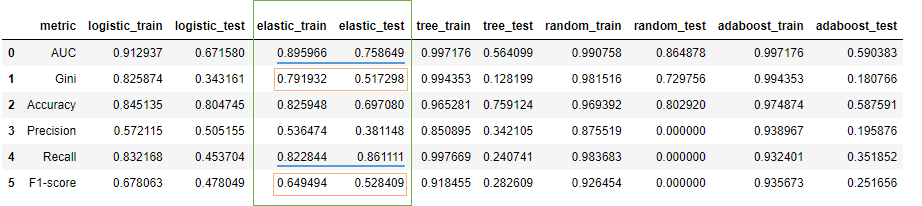

El top 10 deas variables más relevantes del modelo Elastic son:

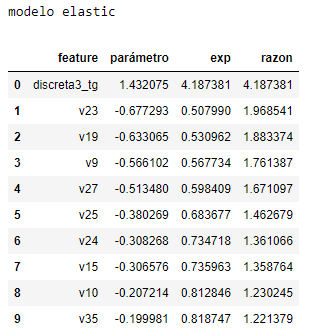

<h3>MÉTRICAS DE LOS MODELOS CON VARIABLES WOE</h3>

In [113]:
#Resumen de todas las métricas del modelo

X_train_woe['probability'] = m_logistic1_woe.predict_proba(X_train_woe[var_woe])[:,1]
X_test_woe['probability']  = m_logistic1_woe.predict_proba(X_test_woe[var_woe])[:,1]
X_train_woe['prediction'] = m_logistic1_woe.predict(X_train_woe[var_woe])
X_test_woe['prediction']  = m_logistic1_woe.predict(X_test_woe[var_woe])

t_metrics_woe = pd.DataFrame({'metric_woe':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'logistic_train':[roc_auc_score(y_train_woe, X_train_woe.probability),
                                        (roc_auc_score(y_train_woe, X_train_woe.probability)*2-1),
                                        accuracy_score(y_train_woe, X_train_woe.prediction),
                                        precision_score(y_train_woe, X_train_woe.prediction),
                                        recall_score(y_train_woe, X_train_woe.prediction),
                                        f1_score(y_train_woe, X_train_woe.prediction)],

                                'logistic_test':[roc_auc_score(y_test_woe, X_test_woe.probability),
                                        (roc_auc_score(y_test_woe, X_test_woe.probability)*2-1),
                                        accuracy_score(y_test_woe, X_test_woe.prediction),
                                        precision_score(y_test_woe, X_test_woe.prediction),
                                        recall_score(y_test_woe, X_test_woe.prediction),
                                        f1_score(y_test_woe, X_test_woe.prediction)]})

X_train_woe['probability'] = m_elastic1_woe.predict_proba(X_train_woe[var_woe])[:,1]
X_test_woe['probability']  = m_elastic1_woe.predict_proba(X_test_woe[var_woe])[:,1]
X_train_woe['prediction'] = m_elastic1_woe.predict(X_train_woe[var_woe])
X_test_woe['prediction']  = m_elastic1_woe.predict(X_test_woe[var_woe])

tt1 = pd.DataFrame({'metric_woe':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'elastic_train':[roc_auc_score(y_train_woe, X_train_woe.probability),
                                        (roc_auc_score(y_train_woe, X_train_woe.probability)*2-1),
                                        accuracy_score(y_train_woe, X_train_woe.prediction),
                                        precision_score(y_train_woe, X_train_woe.prediction),
                                        recall_score(y_train_woe, X_train_woe.prediction),
                                        f1_score(y_train_woe, X_train_woe.prediction)],

                                'elastic_test':[roc_auc_score(y_test_woe, X_test_woe.probability),
                                        (roc_auc_score(y_test_woe, X_test_woe.probability)*2-1),
                                        accuracy_score(y_test_woe, X_test_woe.prediction),
                                        precision_score(y_test_woe, X_test_woe.prediction),
                                        recall_score(y_test_woe, X_test_woe.prediction),
                                        f1_score(y_test_woe, X_test_woe.prediction)]})

t_metrics_woe = pd.merge(t_metrics_woe, tt1, on = 'metric_woe', how='left') 

X_train_woe['probability'] = m_tree1_woe.predict_proba(X_train_woe[var_woe])[:,1]
X_test_woe['probability']  = m_tree1_woe.predict_proba(X_test_woe[var_woe])[:,1]
X_train_woe['prediction'] = m_tree1_woe.predict(X_train_woe[var_woe])
X_test_woe['prediction']  = m_tree1_woe.predict(X_test_woe[var_woe])

tt2 = pd.DataFrame({'metric_woe':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'tree_train':[roc_auc_score(y_train_woe, X_train_woe.probability),
                                        (roc_auc_score(y_train_woe, X_train_woe.probability)*2-1),
                                        accuracy_score(y_train_woe, X_train_woe.prediction),
                                        precision_score(y_train_woe, X_train_woe.prediction),
                                        recall_score(y_train_woe, X_train_woe.prediction),
                                        f1_score(y_train_woe, X_train_woe.prediction)],

                                'tree_test':[roc_auc_score(y_test_woe, X_test_woe.probability),
                                        (roc_auc_score(y_test_woe, X_test_woe.probability)*2-1),
                                        accuracy_score(y_test_woe, X_test_woe.prediction),
                                        precision_score(y_test_woe, X_test_woe.prediction),
                                        recall_score(y_test_woe, X_test_woe.prediction),
                                        f1_score(y_test_woe, X_test_woe.prediction)]})

t_metrics_woe = pd.merge(t_metrics_woe, tt2, on = 'metric_woe', how='left') 

X_train_woe['probability'] = m_random1_woe.predict_proba(X_train_woe[var_woe])[:,1]
X_test_woe['probability']  = m_random1_woe.predict_proba(X_test_woe[var_woe])[:,1]
X_train_woe['prediction'] = m_random1_woe.predict(X_train_woe[var_woe])
X_test_woe['prediction']  = m_random1_woe.predict(X_test_woe[var_woe])

tt3 = pd.DataFrame({'metric_woe':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'random_train':[roc_auc_score(y_train_woe, X_train_woe.probability),
                                        (roc_auc_score(y_train_woe, X_train_woe.probability)*2-1),
                                        accuracy_score(y_train_woe, X_train_woe.prediction),
                                        precision_score(y_train_woe, X_train_woe.prediction),
                                        recall_score(y_train_woe, X_train_woe.prediction),
                                        f1_score(y_train_woe, X_train_woe.prediction)],

                                'random_test':[roc_auc_score(y_test_woe, X_test_woe.probability),
                                        (roc_auc_score(y_test_woe, X_test_woe.probability)*2-1),
                                        accuracy_score(y_test_woe, X_test_woe.prediction),
                                        precision_score(y_test_woe, X_test_woe.prediction),
                                        recall_score(y_test_woe, X_test_woe.prediction),
                                        f1_score(y_test_woe, X_test_woe.prediction)]})

t_metrics_woe = pd.merge(t_metrics_woe, tt3, on = 'metric_woe', how='left') 

X_train_woe['probability'] = m_ada_woe.predict_proba(X_train_woe[var_woe])[:,1]
X_test_woe['probability']  = m_ada_woe.predict_proba(X_test_woe[var_woe])[:,1]
X_train_woe['prediction'] = m_ada_woe.predict(X_train_woe[var_woe])
X_test_woe['prediction']  = m_ada_woe.predict(X_test_woe[var_woe])

tt4 = pd.DataFrame({'metric_woe':['AUC','Gini','Accuracy','Precision','Recall','F1-score'],
                                'adaboost_train':[roc_auc_score(y_train_woe, X_train_woe.probability),
                                        (roc_auc_score(y_train_woe, X_train_woe.probability)*2-1),
                                        accuracy_score(y_train_woe, X_train_woe.prediction),
                                        precision_score(y_train_woe, X_train_woe.prediction),
                                        recall_score(y_train_woe, X_train_woe.prediction),
                                        f1_score(y_train_woe, X_train_woe.prediction)],

                                'adaboost_test':[roc_auc_score(y_test_woe, X_test_woe.probability),
                                        (roc_auc_score(y_test_woe, X_test_woe.probability)*2-1),
                                        accuracy_score(y_test_woe, X_test_woe.prediction),
                                        precision_score(y_test_woe, X_test_woe.prediction),
                                        recall_score(y_test_woe, X_test_woe.prediction),
                                        f1_score(y_test_woe, X_test_woe.prediction)]})

t_metrics_woe = pd.merge(t_metrics_woe, tt4, on = 'metric_woe', how='left') 
t_metrics_woe

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


,metric_woe,logistic_train,logistic_test,elastic_train,elastic_test,tree_train,tree_test,random_train,random_test,adaboost_train,adaboost_test
0,AUC,0.913616,0.924285,0.911757,0.919876,0.987389,0.926768,0.981131,0.954861,0.987360,0.945434
1,Gini,0.827233,0.848569,0.823514,0.839752,0.974777,0.853535,0.962262,0.909722,0.974719,0.890867
2,Accuracy,0.843307,0.841241,0.842394,0.835766,0.918228,0.888686,0.920968,0.903285,0.947008,0.927007
3,Precision,0.571667,0.564417,0.569079,0.554217,0.711149,0.657718,0.729391,0.697842,0.878935,0.809091
4,Recall,0.799534,0.851852,0.806527,0.851852,0.981352,0.907407,0.948718,0.898148,0.846154,0.824074
5,F1-score,0.666667,0.678967,0.667310,0.671533,0.824682,0.762646,0.824721,0.785425,0.862233,0.816514


Se observa que hay presencia de sobreajuste (pero no tanta como en los anteriores modelos), de todo los modelos ajustados con las variables WOE, el mejor es Adaboost

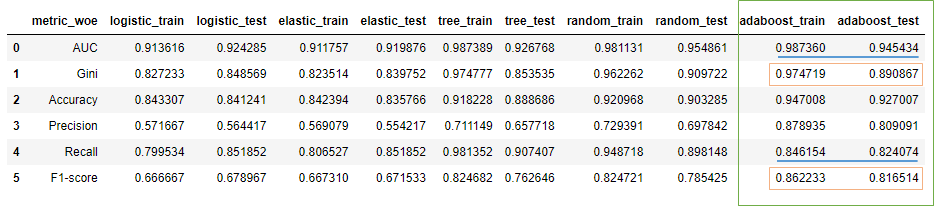

El top 10 de variables más relevantes del modelo Adaboost son:

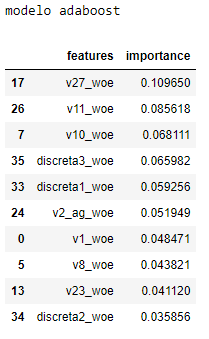

## IMPLEMENTACIÓN

Luego de la creación del modelo, se optó por un modelo Adaboost, este modelo nos otorgará una probabilidad a cada cliente, para poder usar esas probabilidades se sugiere armar grupos de score Alto, Medio y Bajo. Según sea la prioridad a la hora de otorgar el financiamiento a un grupo de personas en específico, se debe tomar como referencia el score alto.

#### OBSERVACIONES

Todos los modelo fueron entredos con todas las variables, para algunos casos esto mejoró el rendimiento del modelo, se podría acomodar más a la realidad los modelos que fueron usados con variables WOE quitando algunas variables. , ya que las métricas son elevadas.